# Taller 3

* Ruben Bohórquez
* Daniel Ramos
* Sebastian Parrado

**Contexto de negocio:**

El área de fidelización de una empresa de telecomunicaciones tiene como una de sus
metas disminuir la tasa de churn (abandono) por parte de sus clientes. Por esta razón,
desea construir modelos de machine learning que permitan predecir si un cliente es
propenso abandonar los servicios que actualmente tiene contratados con la empresa. Una
vez construidos, estos modelos deben ser disponibilizados a través de una API REST que
pueda ser consumida por la plataforma que es usada por los asesores de call center
usando dicha predicción para ofrecer nuevos productos o servicios a los clientes más
propensos al abandono.

<div style="background-color: blue; height: 2px;"></div>

In [1]:
#!pip install shap
from joblib import dump

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ks_2samp
from sklearn.feature_selection import chi2

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score, auc, make_scorer
import shap
import json
from pprint import pprint

<div style="background-color: blue; height: 2px;"></div>

## Carga y Entendimiento de los datos

Cargar bases de datos churn_future.json y churn_historic.json

In [2]:
# Ruta al archivos JSONs
archivo_json1 = './data/churn_future.json'
archivo_json2 = './data/churn_historic.json'
# Abre el archivo JSON y carga los datos

with open(archivo_json1, 'r') as archivo1:
    churn_future_json = json.load(archivo1)

with open(archivo_json2, 'r') as archivo2:
    churn_historic_json = json.load(archivo2)

df_churn_historic = pd.read_json("./data/churn_historic.json")
df_churn_future = pd.read_json("./data/churn_future.json")

<div style="background-color: skyblue; height: 2px;"></div>

### Evaluación Base de Datos churn_historic_json

Se comienza por transformar la base de datos "churn_historic_json" en un DataFrame de Pandas con el fin de simplificar su análisis y aprovechar las funcionalidades que ofrecen las librerias.

In [3]:
df_churn_historic.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,5386-THSLQ,Female,1,Yes,No,66,No,No phone service,DSL,No,...,Yes,No,Yes,No,One year,No,Bank transfer (automatic),45.55,3027.25,No
4,3192-NQECA,Male,0,Yes,No,68,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),110.00,7611.85,Yes


Se procede a verificar los tipos de datos en el DataFrame para asegurar que estén en el formato correcto

In [4]:
# Tipos de datos DataFrame
column_data_types = df_churn_historic.dtypes
print("Tipos de datos que contiene el DataFrame:")
print(column_data_types)

# Resumen de la cantidad de variables por tipo
data_type_counts = column_data_types.value_counts()
print("\nResumen por tipo:")
print(data_type_counts)

Tipos de datos que contiene el DataFrame:
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

Resumen por tipo:
object     18
int64       2
float64     1
Name: count, dtype: int64


La variable "TotalCharges", que representa el costo total generado para el cliente, se transforma en una variable numérica continua.

In [5]:
df_churn_historic['TotalCharges'] = pd.to_numeric(df_churn_historic['TotalCharges'], errors='coerce')
df_churn_historic['TotalCharges'] = df_churn_historic['TotalCharges'].astype('float64')


La variable "SeniorCitizen" se transforma en una variable categórica para mejorar su comprensión y análisis.

In [6]:
df_churn_historic['SeniorCitizen'] = df_churn_historic['SeniorCitizen'].replace({1: 'Yes', 0: 'No'})

**EDA con pandas_profiling:** Biblioteca de Python que automatiza y simplifica el proceso de análisis exploratorio de datos (EDA) al generar informes detallados a partir de un DataFrame de pandas. Ofrece estadísticas resumidas, identificación de valores faltantes, visualizaciones de distribuciones y relaciones, matrices de correlación, tablas de frecuencia y más. 

In [7]:
#from pandas_profiling import ProfileReport
#profile_new = ProfileReport(df_churn_historic)
#profile_new.to_notebook_iframe()

Los registros con tenure = 0 se filtran, ya que se considera una situación inusual que podría deberse a un error en la base de datos. Un cliente con tenure = 0 no tendría permanencia con la empresa de telecomunicaciones.

In [8]:
# Filtrar df_churn_historic por tenure igual a 0
filtered_df = df_churn_historic[df_churn_historic['tenure'] == 0]
filtered_df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
288,4472-LVYGI,Female,No,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
553,3115-CZMZD,Male,No,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
736,5709-LVOEQ,Female,No,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1040,1371-DWPAZ,Female,No,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
2831,7644-OMVMY,Male,No,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3215,3213-VVOLG,Male,No,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
3669,2520-SGTTA,Female,No,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
4507,2923-ARZLG,Male,No,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
5859,4075-WKNIU,Female,No,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No
5943,2775-SEFEE,Male,No,No,Yes,0,Yes,Yes,DSL,Yes,...,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),61.90,NaN,No


In [9]:
from pandas_profiling import ProfileReport
profile_new = ProfileReport(filtered_df)
profile_new.to_notebook_iframe()

numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.


`import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
# Filtrar df_churn_historic por tenure igual a 0, PhoneService igual a 'No' y InternetService igual a 'No'
filtered_df2 = df_churn_historic[(df_churn_historic['tenure'] == 0) & (df_churn_historic['PhoneService'] == 'No') & (df_churn_historic['InternetService'] == 'No')]
num_records = filtered_df2.shape[0]
print(num_records)

0


In [11]:
# Filtrar df_churn_historic por PhoneService igual a 'No' y InternetService igual a 'No'
filtered_df3 = df_churn_historic[(df_churn_historic['PhoneService'] == 'No') & (df_churn_historic['InternetService'] == 'No')]
num_records = filtered_df3.shape[0]
print(num_records)

0


El registro con tenure = 0 se debe a que el cliente es nuevo en la empresa, por lo que no tiene un recargo. Además, se valida que no existan clientes en la base de datos que no tengan al menos un servicio contratado (telefonía o internet).

* **Dimensiones del DataFrame:**

In [12]:
# Dimensiones DataFrame:
DimR = df_churn_historic.shape[0]
DimC = df_churn_historic.shape[1]
DimG = df_churn_historic.shape
print("El DataFrame cuenta con",DimR,"Filas y",DimC,"Columnas.",DimG)

El DataFrame cuenta con 6000 Filas y 21 Columnas. (6000, 21)


* **Tipos de datos que contiene el DataFrame:**

In [13]:
# Tipos de datos DataFrame
column_data_types = df_churn_historic.dtypes
print("Tipos de datos que contiene el DataFrame:")
print(column_data_types)

# Resumen de la cantidad de variables por tipo
data_type_counts = column_data_types.value_counts()
print("\nResumen por tipo:")
print(data_type_counts)

Tipos de datos que contiene el DataFrame:
customerID           object
gender               object
SeniorCitizen        object
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

Resumen por tipo:
object     18
float64     2
int64       1
Name: count, dtype: int64


* **Calidad y Limpiza de Datos:**

Antes de determinar las variables o atributos más importantes, se lleva a cabo un proceso de limpieza en el conjunto de datos con el fin de buscar una mayor eficiencia y precisión en el análisis de las variables relevantes

**- Duplicados**: Se ejecuta un comando para eliminar registros duplicados del DataFrame con el objetivo de asegurar la integridad y consistencia de los datos, evitando la redundancia de información que podría distorsionar los resultados del análisis

In [14]:
# Antes de eliminar duplicados
num_registros_antes = df_churn_historic.shape[0]

# Eliminar duplicados
gapminder =df_churn_historic.drop_duplicates()

# Después de eliminar duplicados
num_registros_despues = df_churn_historic.shape[0]

# Calcular el número de duplicados eliminados
num_duplicados_eliminados = num_registros_antes - num_registros_despues

# Imprimir el número de duplicados eliminados
print(f'Se eliminaron {num_duplicados_eliminados} registros duplicados.')

Se eliminaron 0 registros duplicados.


**-  Completitud**: El objetivo es verificar la integridad de los datos, evaluando la cantidad de registros faltantes en cada columna. Aquellas columnas que presenten un porcentaje de valores nulos superior al 8% serán excluidas del análisis, siguiendo la recomendación establecida para el curso.

In [15]:
#Identificar Columnas vacias y datos incompletos 

# Contar la cantidad total de registros en el DataFrame
total_registros = len(df_churn_historic)

# Contar la cantidad de registros nulos en cada columna
registros_nulos_por_columna = df_churn_historic.isnull().sum()

# Calcular la frecuencia relativa de valores nulos en cada columna en términos porcentuales
frecuencia_relativa = (registros_nulos_por_columna / total_registros) * 100

umbral_relevancia = 8

# Crear un nuevo DataFrame con los resultados
resultados_df = pd.DataFrame({
    "Columnas": df_churn_historic.columns,
    "Cantidad de Registros Nulos": registros_nulos_por_columna,
    "Frecuencia Relativa (%)": frecuencia_relativa,
    "Relevancia": ["No relevante" if x > umbral_relevancia else "Relevante" for x in frecuencia_relativa]
})


# Formatear el DataFrame como una cadena de texto
tabla_resultados = resultados_df.to_string(index=False)

# Filtrar las columnas no relevantes
columnas_descartadas = resultados_df[resultados_df["Relevancia"] == "No relevante"]["Columnas"].tolist()

# Imprimir la tabla de resultados
print(tabla_resultados)
print("\nColumnas Descartadas:")
print(columnas_descartadas)

        Columnas  Cantidad de Registros Nulos  Frecuencia Relativa (%) Relevancia
      customerID                            0                 0.000000  Relevante
          gender                            0                 0.000000  Relevante
   SeniorCitizen                            0                 0.000000  Relevante
         Partner                            0                 0.000000  Relevante
      Dependents                            0                 0.000000  Relevante
          tenure                            0                 0.000000  Relevante
    PhoneService                            0                 0.000000  Relevante
   MultipleLines                            0                 0.000000  Relevante
 InternetService                            0                 0.000000  Relevante
  OnlineSecurity                            0                 0.000000  Relevante
    OnlineBackup                            0                 0.000000  Relevante
DeviceProtection

In [16]:
df_churn_historic[df_churn_historic['TotalCharges'].isnull()]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
288,4472-LVYGI,Female,No,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
553,3115-CZMZD,Male,No,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
736,5709-LVOEQ,Female,No,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1040,1371-DWPAZ,Female,No,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
2831,7644-OMVMY,Male,No,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3215,3213-VVOLG,Male,No,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
3669,2520-SGTTA,Female,No,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
4507,2923-ARZLG,Male,No,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
5859,4075-WKNIU,Female,No,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No
5943,2775-SEFEE,Male,No,No,Yes,0,Yes,Yes,DSL,Yes,...,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),61.90,NaN,No


Se identifica un registro nulo en TotalCharges. La razón es que el cliente no ha completado su primer mes de permanencia. Por lo tanto, se reemplaza el valor nulo por 0.

In [17]:
df_churn_historic["TotalCharges"].fillna(0, inplace=True)

**- Consistencia:** Coherencia y uniformidad de los datos en términos de formato, estructura y contenido 

In [18]:
unique_values_per_column = {}

for column in df_churn_historic.columns:
    unique_values_per_column[column] = df_churn_historic[column].unique()

# Imprimir los valores únicos de cada columna de manera organizada
for column, unique_values in unique_values_per_column.items():
    print(f"Valores únicos en la columna '{column}':")
    for value in unique_values:
        print(f" - {value}")
    print()  # Agregar una línea en blanco para separar las columnas

Valores únicos en la columna 'customerID':
 - 7590-VHVEG
 - 5575-GNVDE
 - 3668-QPYBK
 - 5386-THSLQ
 - 3192-NQECA
 - 6180-YBIQI
 - 6728-DKUCO
 - 9750-BOOHV
 - 8597-CWYHH
 - 2848-YXSMW
 - 0486-HECZI
 - 4549-ZDQYY
 - 5712-AHQNN
 - 4846-WHAFZ
 - 5256-SKJGO
 - 3071-VBYPO
 - 9560-BBZXK
 - 5299-RULOA
 - 8402-OOOHJ
 - 9445-ZUEQE
 - 1091-SOZGA
 - 2928-HLDBA
 - 0404-SWRVG
 - 6497-TILVL
 - 7219-TLZHO
 - 4622-YNKIJ
 - 4412-YLTKF
 - 6734-PSBAW
 - 3930-ZGWVE
 - 2639-UGMAZ
 - 2876-GZYZC
 - 6207-WIOLX
 - 8587-XYZSF
 - 3091-FYHKI
 - 2372-HWUHI
 - 7799-LGRDP
 - 7850-VWJUU
 - 3774-VBNXY
 - 6217-KDYWC
 - 0390-DCFDQ
 - 3146-MSEGF
 - 4080-OGPJL
 - 1095-WGNGG
 - 2636-SJDOU
 - 1131-QQZEB
 - 5716-EZXZN
 - 6837-BJYDQ
 - 2135-RXIHG
 - 6440-DKQGE
 - 3466-BYAVD
 - 3780-YVMFA
 - 3874-EQOEP
 - 1679-JRFBR
 - 9073-ZZIAY
 - 3077-RSNTJ
 - 6551-GNYDG
 - 9167-APMXZ
 - 2749-CTKAJ
 - 6371-NZYEG
 - 7554-NEWDD
 - 8992-VONJD
 - 0867-MKZVY
 - 4482-EWFMI
 - 4648-YPBTM
 - 2907-ILJBN
 - 6345-FZOQH
 - 3376-BMGFE
 - 5997-OPVFA
 - 34

La informació se ajusta a los niveles de las variables descritas en el documento.

**- Relevancia:** Información adecuada para respaldar los requisitos (análisis de variables no numéricas).

La variable "customerID", que corresponde al identificador del cliente, se considera de poca relevancia en la creación de un modelo de machine learning, ya que previamente se verificó que no existen registros duplicados para el mismo cliente, lo que la hace irrelevante en el análisis y se procede a su eleminación.

In [19]:
df_churn_historic = df_churn_historic.drop("customerID", axis=1)

## Conclusiones Carga y Entendimiento de los datos

Se ha llevado a cabo una exhaustiva revisión de las bases de datos "churn_future.json" y "churn_historic.json". Se ha confirmado que no existen registros duplicados ni registros dobles para un mismo cliente en ambas bases de datos.

En el proceso de análisis, se evaluaron los registros en los cuales la duración de la permanencia del cliente, representada por la variable "tenure", fuera igual a 0. Esto se hizo como un criterio inicial de sospecha de posibles errores. Sin embargo, tras un análisis más detenido, se determinó que estos registros corresponden a clientes que recientemente se incorporaron a la base de datos, lo que justifica esta condición.

Se observó que la totalidad de los registros está completo, con la excepción de algunos registros en la variable "TotalCharges" en ambas bases de datos. No obstante, esta falta de datos se relaciona directamente con la duración de los clientes, es decir, aquellos con una duración ("tenure") igual a 0. En estos casos, los valores nulos se han imputado con el valor 0, ya que esto indica que no se han realizado cargos a esos clientes aún.

También se verificó que no existen clientes registrados que no cuenten con servicios de internet ni telefonía, lo cual es coherente con la naturaleza de la empresa de telecomunicaciones. En resumen, ambas bases de datos presentan una alta calidad en sus datos.

En una primera evaluación, se ha descartado la utilización de la variable "customerID" en el análisis, ya que no aporta valor y se ha corroborado que no existen registros duplicados de clientes.

<div style="background-color: skyblue; height: 2px;"></div>

## Analisis de las features y su relación con la variable objetivo

Con el propósito de identificar las características que deben ser consideradas en la construcción de un Pipeline, se realiza un análisis exhaustivo de su relación con la variable de interés, "Churn". Además, se aplican dos pruebas estadísticas, Kolmogorov-Smirnov (KS) para características numéricas y Chi2 para características categóricas, con el objetivo de determinar su relevancia empíricamente.

En el caso de la prueba Kolmogorov-Smirnov (KS), se utiliza debido a su naturaleza no paramétrica, lo que significa que no es necesario que los datos sigan una distribución normal. Esta prueba nos proporciona un valor estadístico y un p-valor que permiten determinar si existe una diferencia significativa entre la distribución de la variable para las clases positivas y negativas. Si el valor del estadístico KS es bajo, indica que las distribuciones son similares, lo que no es relevante para nuestro análisis.

Por otro lado, cuando tratamos con características categóricas, se aplica un proceso conocido como codificación one-hot (one-hot encoding) antes de la prueba Chi2. La prueba Chi2 evalúa la relación entre una característica categórica específica y su impacto en la variable de interés, es decir, si hay una relación significativa entre un valor particular de la característica y la clasificación en las clases positivas o negativas. Un valor alto en la estadística Chi2 indica una mayor diferencia en la relación entre la característica categórica y la variable de interés, lo que sugiere una mayor relevancia de dicha característica en el análisis.

En resumen, a través de estas pruebas, determinamos la importancia de las características tanto numéricas como categóricas en relación con la variable "Churn" y evaluamos si existen diferencias significativas en sus distribuciones o relaciones, lo que contribuye a la toma de decisiones informadas en la construcción del Pipeline.

En este proceso, se hará uso exclusivamente del DataFrame histórico, que servirá como conjunto de entrenamiento para el modelo. Posteriormente, este modelo será validado y probado utilizando el DataFrame que contiene registros futuros.

* **Balanceo:**

Se realiza una evaluación de la proporción de registros para las clases positivas (Yes) y negativas (No).

In [20]:
df_churn_historic["Churn"].value_counts(dropna=False, normalize=True)

Churn
No     0.734667
Yes    0.265333
Name: proportion, dtype: float64

Basándonos en los resultados, se puede concluir que la variable "Churn" presenta una proporción desigual entre las clases "No" y "Yes". La clase "No" representa aproximadamente el 73.47% de los registros, mientras que la clase "Yes" representa aproximadamente el 26.53%.Es importante tener en cuenta que un desequilibrio significativo en la proporción de clases puede afectar el rendimiento del modelo. 

* **Distribución de las variables numericas entre clase positiva y negativa:** 

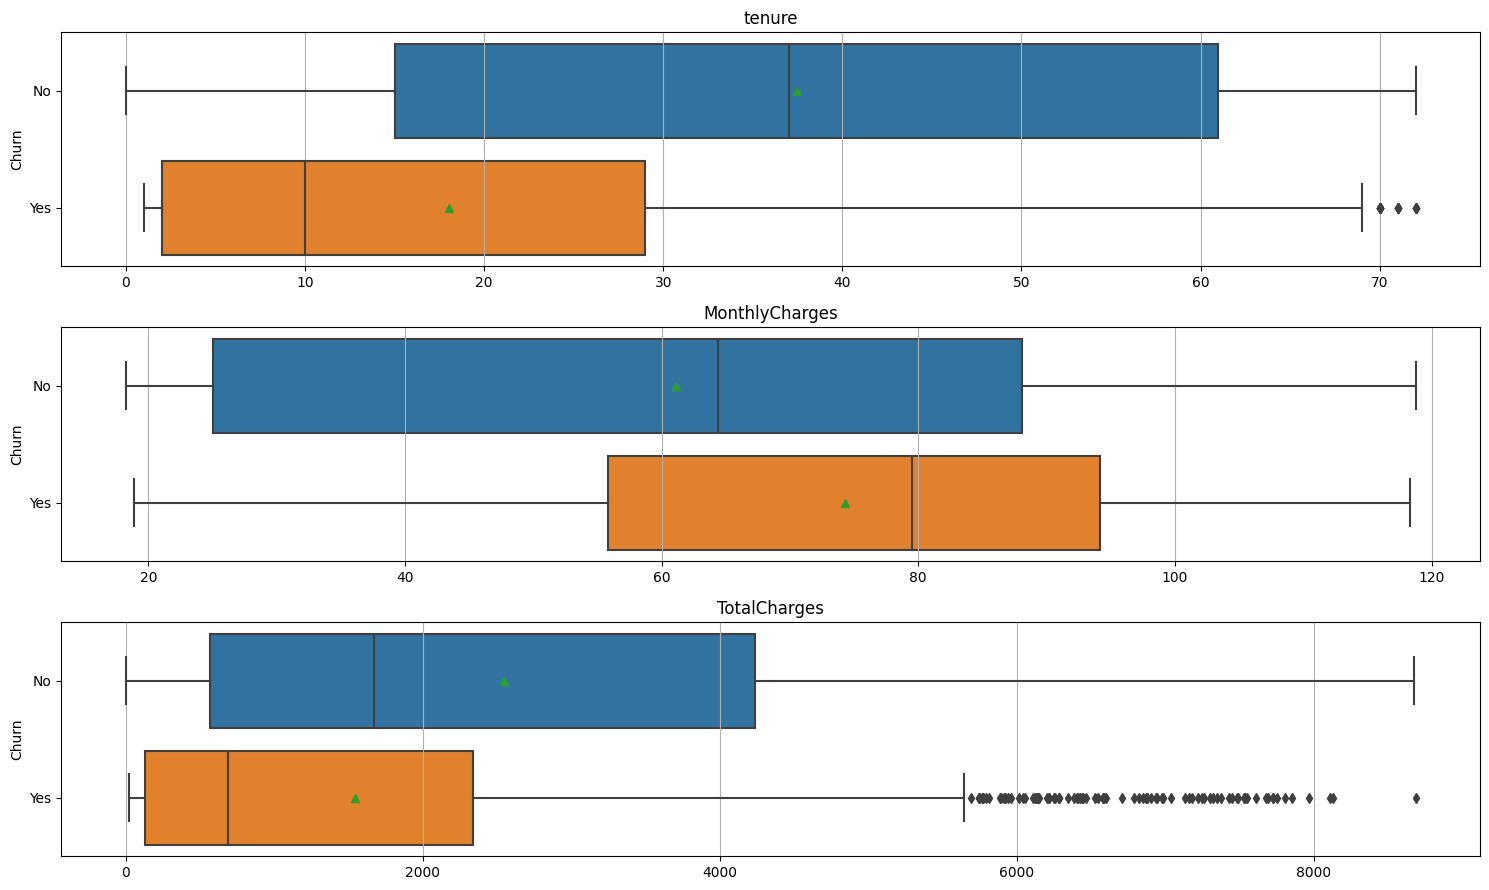

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# Filtrar solo las columnas numéricas
numeric_columns = df_churn_historic.select_dtypes(include=['number'])

# Establecer el tamaño de la figura
fig, axes = plt.subplots(len(numeric_columns.columns), 1, figsize=(15, 3 * len(numeric_columns.columns)))

# Iterar a través de las columnas numéricas y crear gráficos boxplot
for i, column in enumerate(numeric_columns.columns):
    sns.boxplot(data=df_churn_historic, x=column, y="Churn", showmeans=True, orient="h", ax=axes[i])
    axes[i].set_title(column)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Churn')
    axes[i].grid(axis='x')

# Ajustar la disposición de las gráficas
plt.tight_layout()
plt.show()


Aparentemente, las tres variables numéricas resultan relevantes, ya que muestran diferencias en la distribución de los datos según la clasificación en las clases positivas o negativas.

* **Distribución de las variables categoricas entre clase positiva y negativa:** 

In [22]:
# Obtén la lista de columnas categóricas
categorical_columns = df_churn_historic.select_dtypes(include=['object']).columns

# Filtra las columnas numéricas y exclúyelas de la lista
numeric_columns = df_churn_historic.select_dtypes(include=['number']).columns
categorical_columns = categorical_columns.difference(numeric_columns)

# Crea un diccionario para almacenar las tablas cruzadas
crosstab_dict = {}

# Itera a través de las columnas categóricas y crea las tablas cruzadas
for column in categorical_columns:
    crosstab = pd.crosstab(df_churn_historic["Churn"], df_churn_historic[column], normalize="columns")
    crosstab_dict[column] = crosstab

# Ahora crosstab_dict contiene las tablas cruzadas solo para columnas categóricas
for column, crosstab in crosstab_dict.items():
    print(f"Tabla Cruzada para la columna '{column}':")
    print(crosstab)
    print("\n")



Tabla Cruzada para la columna 'Churn':
Churn   No  Yes
Churn          
No     1.0  0.0
Yes    0.0  1.0


Tabla Cruzada para la columna 'Contract':
Contract  Month-to-month  One year  Two year
Churn                                       
No              0.574552   0.88141  0.970528
Yes             0.425448   0.11859  0.029472


Tabla Cruzada para la columna 'Dependents':
Dependents       No       Yes
Churn                        
No          0.68465  0.850359
Yes         0.31535  0.149641


Tabla Cruzada para la columna 'DeviceProtection':
DeviceProtection        No  No internet service       Yes
Churn                                                    
No                0.603817             0.926236  0.778692
Yes               0.396183             0.073764  0.221308


Tabla Cruzada para la columna 'InternetService':
InternetService       DSL  Fiber optic        No
Churn                                           
No               0.808831     0.580412  0.926236
Yes              0.191169

* Contrato (Contract): Los clientes con contratos a corto plazo (Month-to-month) tienen una tasa de abandono (Churn) más alta en comparación con los contratos a largo plazo (One year y Two year), donde la tasa de abandono disminuye significativamente.

* Dependientes (Dependents): Los clientes sin dependientes (No) tienden a tener una tasa de abandono más alta en comparación con aquellos que tienen dependientes (Yes).

* Protección de Dispositivo (DeviceProtection): Los clientes que no tienen servicio de protección de dispositivo (No) tienen una tasa de abandono más alta en comparación con aquellos que tienen (Yes). Además, la tasa de abandono es muy baja para aquellos que no tienen servicio de Internet.

* Tipo de Servicio de Internet (InternetService): Los clientes con servicio de fibra óptica (Fiber optic) muestran una tasa de abandono más alta en comparación con los que tienen servicio DSL o no tienen servicio de Internet.

* Líneas Múltiples (MultipleLines): No parece haber una gran diferencia en la tasa de abandono entre aquellos que tienen líneas múltiples (Yes) y los que no las tienen (No).

* Copia de Seguridad en Línea (OnlineBackup) y Seguridad en Línea (OnlineSecurity): Los clientes que no tienen servicio de copia de seguridad en línea ni seguridad en línea tienden a tener una tasa de abandono más alta. Además, la tasa de abandono es muy baja para aquellos que no tienen servicio de Internet.

* Facturación Electrónica (PaperlessBilling): Los clientes con facturación electrónica (Yes) tienen una tasa de abandono más alta en comparación con aquellos que no la tienen (No).

* Socios (Partner): Los clientes sin socios (No) tienen una tasa de abandono más alta en comparación con aquellos que tienen socios (Yes).

* Método de Pago (PaymentMethod): El método de pago influye en la tasa de abandono. Los clientes que utilizan métodos de pago electrónicos (Electronic check) muestran una tasa de abandono más alta en comparación con los métodos de pago automáticos o el pago por correo (Mailed check).

* Servicio de Teléfono (PhoneService): La disponibilidad de servicio de teléfono no parece tener un gran impacto en la tasa de abandono.

* Cliente Senior (SeniorCitizen): Los clientes senior (Yes) tienen una tasa de abandono más alta en comparación con los no senior (No).

* Películas en Streaming (StreamingMovies) y Televisión en Streaming (StreamingTV): Los clientes que no tienen servicio de streaming de películas o televisión tienden a tener una tasa de abandono más alta.

* Soporte Técnico (TechSupport): Los clientes que no tienen servicio de soporte técnico tienden a tener una tasa de abandono más alta.

* Género (gender): No parece haber una gran diferencia en la tasa de abandono entre géneros (Female y Male).

* **Selección Variables Numericas Relevantes (Kolmogorov-Smirnov):**

In [23]:
numeric_columns = df_churn_historic.select_dtypes(include=['number']).columns
numeric_columns

Index(['tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')

In [24]:
numerical_features = numeric_columns

In [25]:
ks_results = []
for f in numerical_features:
    ks_stat, p_value = ks_2samp(df_churn_historic.loc[df_churn_historic["Churn"] =="Yes", f], df_churn_historic.loc[df_churn_historic["Churn"] == "No", f])
    ks_results.append({
        "Feature": f,
        "KS stat": ks_stat,
        "p-value": p_value
    })
pd.DataFrame(ks_results)

,Feature,KS stat,p-value
0,tenure,0.352330,1.348587e-129
1,MonthlyCharges,0.248452,6.368070e-64
2,TotalCharges,0.221103,1.333608e-50


- Una alto estadístico de KS (y un pequeño valor de p menor a 0.05) indica que las distribuciones de la característica son significativamente diferentes entre las dos clases. Esto sugiere que la característica podría ser discriminatoria y útil para la clasificación.
- Por otro lado, una baja estadístico de KS (y un valor de p grande mayor a 0.05) sugiere que la característica tiene una distribución similar en ambas clases y puede que no sea tan informativa.

Como criterio empírico establecido para este curso, se consideran relevantes todas aquellas variables cuyo estadístico sea mayor a 0.1 y, en este caso, las tres evaluadas cumplen con este criterio, por lo que se consideran relevantes para ser incluidas en el modelo.

In [26]:
import pandas as pd
ks_results=pd.DataFrame(ks_results)

filtered_results = ks_results[(ks_results['KS stat'] > 0.1) & (ks_results['p-value'] <= 0.5)]

# Obtener las características únicas de la columna 'Feature' en el DataFrame filtrado
unique_features = filtered_results['Feature'].unique()

# Mostrar las características únicas
print(unique_features)


['tenure' 'MonthlyCharges' 'TotalCharges']


In [27]:
numeric_columns = df_churn_historic.select_dtypes(include=['number']).columns
correlation_matrix = df_churn_historic[numeric_columns].corr()

print(correlation_matrix)


                  tenure  MonthlyCharges  TotalCharges
tenure          1.000000        0.255071      0.827185
MonthlyCharges  0.255071        1.000000      0.654090
TotalCharges    0.827185        0.654090      1.000000


Como criterio establecido en el curso, se ha determinado que cuando dos variables presentan una correlación del 90% o superior, una de ellas debe ser descartada para evitar la multicolinealidad. A pesar de que la matriz de correlación indica una alta correlación entre las variables "Tenure" y "TotalCharges," lo cual es coherente con la intuición, ya que una mayor duración de permanencia del cliente se traduce en mayores cargos totales, se ha decidido conservar ambas variables, ya que no superan el umbral definido. 

* **Selección Variables Categoricas Relevantes (Chi2):**

In [28]:
# Obtén la lista de columnas categóricas
categorical_columns = df_churn_historic.select_dtypes(include=['object']).columns

# Filtra las columnas numéricas y exclúyelas de la lista
numeric_columns = df_churn_historic.select_dtypes(include=['number']).columns
categorical_columns = categorical_columns.difference(numeric_columns)


In [29]:
categorical_features =categorical_columns.drop("Churn")

In [30]:
chi2_results = []
for f in categorical_features:
    onehot = OneHotEncoder(sparse=False)
    t = onehot.fit_transform(df_churn_historic[[f]])
    values = onehot.categories_[0]
    chi2_stats, p_values = chi2(t, df_churn_historic["Churn"])
    
    for value, chi_stat, p_value in zip(values, chi2_stats, p_values):
        chi2_results.append({
            "Feature": f,
            "Value": value,
            "Chi2 stat": chi_stat,
            "p-value": p_value
        })
pd.DataFrame(chi2_results)

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1

,Feature,Value,Chi2 stat,p-value
0,Contract,Month-to-month,433.083241,3.465982e-96
1,Contract,One year,137.863949,7.804472e-32
2,Contract,Two year,416.376062,1.500539e-92
3,Dependents,No,53.759217,2.266285e-13
4,Dependents,Yes,124.349729,7.063046e-29
5,DeviceProtection,No,230.126034,5.595730e-52
6,DeviceProtection,No internet service,247.567943,8.803599e-56
7,DeviceProtection,Yes,20.533026,5.861121e-06
8,InternetService,DSL,58.154337,2.423393e-14
9,InternetService,Fiber optic,320.302730,1.244401e-71


- Una característica con un alto valor estadístico y un valor p bajo se considera más relevante para la tarea de clasificación porque tiene una asociación significativa con la variable objetivo. Tal característica puede mejorar potencialmente el rendimiento de un clasificador.

- Por el contrario, una característica con un valor estadístico bajo y un valor p alto podría no ser muy informativa para la tarea de clasificación, ya que no parece tener una relación sólida con la variable objetivo

Las variables que tengan al menos un nivel con un estadístico superior a 100 se incluirán en el modelo como definición empírica del curso.

Se presentan las variables Categoricas que cumplen con el criterio mencionado anteriormente, resaltando que todas ellas poseen un p-valor menor a 0.05

In [31]:
import pandas as pd
chi2_results=pd.DataFrame(chi2_results)
# Supongamos que tienes un DataFrame chi2_results con una columna 'Chi2_stat' y una columna 'Feature'
# Filtrar por resultados Chi2_stat > 100
filtered_results = chi2_results[chi2_results['Chi2 stat'] > 100]

# Obtener las características únicas de la columna 'Feature' en el DataFrame filtrado
unique_features = filtered_results['Feature'].unique()

# Mostrar las características únicas
print(unique_features)


['Contract' 'Dependents' 'DeviceProtection' 'InternetService'
 'OnlineBackup' 'OnlineSecurity' 'PaperlessBilling' 'PaymentMethod'
 'SeniorCitizen' 'StreamingMovies' 'StreamingTV' 'TechSupport']


<div style="background-color: blue; height: 2px;"></div>

### 1. [20%] Integración del proceso de transformación de datos, entrenamiento y predicción: 
Utilizando la función Pipeline de Scikit-Learn, encapsule los procesos
secuenciales de transformación, entrenamiento y predicción requeridos para dar
solución al problema planteado. Tenga en cuenta que a partir de los datos
originales el pipeline debe estar en capacidad de realizar todas las
transformaciones de datos necesarias para realizar las labores de entrenamiento y
predicción. Es decir, posterior a las fases de exploración y análisis de calidad de los
datos, no se deben implementar procesos de transformación de datos por fuera
del pipeline.

Con base en el punto anterior se definen las funciones para Transformar la Base de datos Original y Construir el Pipeline

In [32]:
features = ["tenure",
            "MonthlyCharges",
            "TotalCharges",
            "Contract",
            "Dependents",
            "DeviceProtection",
            "InternetService",
            "OnlineBackup",
            "OnlineSecurity",
            "PaperlessBilling",
            "PaymentMethod",
            "SeniorCitizen",
            "StreamingMovies",
            "StreamingTV",
            "TechSupport"]
target = "Churn"

In [33]:
import pandas as pd
import json
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#Define features and target
features = ["tenure",
            "MonthlyCharges",
            "TotalCharges",
            "Contract",
            "Dependents",
            "DeviceProtection",
            "InternetService",
            "OnlineBackup",
            "OnlineSecurity",
            "PaperlessBilling",
            "PaymentMethod",
            "SeniorCitizen",
            "StreamingMovies",
            "StreamingTV",
            "TechSupport"]

# Define the list of categorical features you want to one-hot encode
categorical_features = ["Contract",
                        #"Dependents",
                        "DeviceProtection",
                        "InternetService",
                        "OnlineBackup",
                        "OnlineSecurity",
                        #"PaperlessBilling",
                        "PaymentMethod",
                        #"SeniorCitizen",
                        "StreamingMovies",
                        "StreamingTV",
                        "TechSupport"]

target = ["Churn"]

# Define a custom transformer to read JSON and convert it to a DataFrame
class JSONToDataFrameTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Assuming X is a file path to the JSON file
        with open(X) as json_file:
            data = json.load(json_file)
        
        df = pd.DataFrame(data)
        return df

# Define a custom transformer to keep only the specified columns
class SelectColumnsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, features):
        self.features = features

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.features + target]

class ConvertColumnsToBinaryTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Convertir "Yes" en 1 y "No" en 0 en la columna "Churn"
        X['Dependents'] = X['Dependents'].map({'Yes': 1, 'No': 0})
        X['PaperlessBilling'] = X['PaperlessBilling'].map({'Yes': 1, 'No': 0})
        return X

# Define a custom transformer to one-hot encode categorical features
class OneHotEncodeCategorical(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        onehot_encoded = []
        for f in categorical_features:
            onehot = OneHotEncoder(sparse=False)
            onehot_result = onehot.fit_transform(X[[f]])
            categories = onehot.get_feature_names_out([f])
            onehot_df = pd.DataFrame(onehot_result, columns=categories)
            onehot_encoded.append(onehot_df)
        
        # Concatenar las columnas codificadas con las columnas numéricas originales
        numeric_features = list(set(X.columns) - set(categorical_features))
        numeric_df = X[numeric_features]
        
        # Concatenar todas las columnas
        result_df = pd.concat([numeric_df] + onehot_encoded, axis=1)
        
        return result_df

    
class ReplaceNullsTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy['TotalCharges'] = X_copy['TotalCharges'].replace('', '0').astype(float)
        return X_copy

#class ConvertChurnToBinaryTransformer(BaseEstimator, TransformerMixin):
#    def fit(self, X, y=None):
#        return self

#    def transform(self, X):
#        # Convertir "Yes" en 1 y "No" en 0 en la columna "Churn"
#        X['Churn'] = X['Churn'].map({'Yes': 1, 'No': 0})
#        return X
# Create the pipeline for transformations, excluding the model

preprocessing_pipeline = Pipeline([
    ('json_to_dataframe', JSONToDataFrameTransformer()),
    ('select_columns', SelectColumnsTransformer(features)),
    ('replace_nulls', ReplaceNullsTransformer()),
#    ('convert_churn', ConvertChurnToBinaryTransformer()),
    ('convert_to_bin', ConvertColumnsToBinaryTransformer()),
    ('onehot_encode_categorical', OneHotEncodeCategorical())
])

In [34]:
#After showing the transformation required, a function was generated
import sys
sys.path.append("functions")
from preprocessing_training import preprocessing_json

In [35]:
#Using define function, Not CHURN included
df = preprocessing_json('./data/churn_historic.json')

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


In [36]:
len(df.columns)

35

In [37]:
df.columns

Index(['Churn', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'Dependents', 'DeviceProtection_No',
       'DeviceProtection_No internet service', 'DeviceProtection_Yes',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No', 'MonthlyCharges', 'OnlineBackup_No',
       'OnlineBackup_No internet service', 'OnlineBackup_Yes',
       'OnlineSecurity_No', 'OnlineSecurity_No internet service',
       'OnlineSecurity_Yes', 'PaperlessBilling',
       'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'SeniorCitizen', 'StreamingMovies_No',
       'StreamingMovies_No internet service', 'StreamingMovies_Yes',
       'StreamingTV_No', 'StreamingTV_No internet service', 'StreamingTV_Yes',
       'TechSupport_No', 'TechSupport_No internet service', 'TechSupport_Yes',
       'TotalCharges', 'tenure'],
      dtype='object

In [38]:
#using the transformation pipeline
df = preprocessing_pipeline.fit_transform('./data/churn_historic.json')

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1

In [39]:
cols = df.columns.tolist()
cols.sort()
df = df[cols]

In [40]:
df.columns

Index(['Churn', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'Dependents', 'DeviceProtection_No',
       'DeviceProtection_No internet service', 'DeviceProtection_Yes',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No', 'MonthlyCharges', 'OnlineBackup_No',
       'OnlineBackup_No internet service', 'OnlineBackup_Yes',
       'OnlineSecurity_No', 'OnlineSecurity_No internet service',
       'OnlineSecurity_Yes', 'PaperlessBilling',
       'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'SeniorCitizen', 'StreamingMovies_No',
       'StreamingMovies_No internet service', 'StreamingMovies_Yes',
       'StreamingTV_No', 'StreamingTV_No internet service', 'StreamingTV_Yes',
       'TechSupport_No', 'TechSupport_No internet service', 'TechSupport_Yes',
       'TotalCharges', 'tenure'],
      dtype='object

### 2. [10%] Entrenamiento de un modelo baseline: 
Utilizando un algoritmo simple y sin mayores consideraciones a nivel de experimentación, transformación de datos y
selección de hiper-parámetros, entrene un primer modelo de clasificación. Reporte sus métricas de error.

In [41]:
# Leer y transformar los datos desde el archivo JSON y aplicar el modelo
df = preprocessing_json('./data/churn_historic.json')

cols = df.columns.tolist()
cols.sort()
df = df[cols]

# Dividir los datos en conjunto de entrenamiento y prueba
df["Churn"] = df["Churn"].replace("Yes", 1)
df["Churn"] = df["Churn"].replace("No", 0)
X = df.drop("Churn", axis=1)  # Eliminar la columna de destino 'Churn'
y = df["Churn"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Crear un nuevo pipeline que primero realice el preprocesamiento y luego aplique el modelo
class_model = LogisticRegression()

pipeline_Baseline = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('model', class_model)
])

# Entrenar el modelo dentro del pipeline
pipeline_Baseline.named_steps['model'].fit(X_train, y_train)

# Realizar predicciones
y_pred = pipeline_Baseline.named_steps['model'].predict(X_test)


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [43]:
valores_churn = df['Churn'].unique()
print(valores_churn)

[0 1]


In [44]:
from sklearn.metrics import classification_report, roc_auc_score

# Generar el informe de clasificación
report = classification_report(y_test, y_pred, output_dict=True, labels=[0, 1])

# Imprimir el informe de clasificación
print("Classification Report:")
for label, metrics in report.items():
    if label in ["0", "1"]:  # Ajusta las etiquetas según tus datos
        print(f"Label: {label}")
        print(f"Precision: {metrics['precision']:.2f}")
        print(f"Recall: {metrics['recall']:.2f}")
        print(f"F1 Score: {metrics['f1-score']:.2f}")
        print('--')

# Calcular ROC AUC utilizando las probabilidades de predicción
y_pred_proba = pipeline_Baseline.named_steps['model'].predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC: {roc_auc:.2f}")


Classification Report:
Label: 0
Precision: 0.82
Recall: 0.90
F1 Score: 0.86
--
Label: 1
Precision: 0.66
Recall: 0.50
F1 Score: 0.57
--
ROC AUC: 0.83


Precisión: La precisión para la clase positiva es de 0,66, lo que indica que el 66 % de las predicciones etiquetadas como positivas son realmente positivas. Esto sugiere que el modelo es relativamente preciso para identificar casos positivos.

Recall: El recall para la clase positiva es de 0,50, lo que significa que el modelo identifica correctamente el 50 % de los casos positivos reales. Esto sugiere que el modelo esta omitiendo el 50% de casos positivos reales, lo cual no es una situación favorable.

Puntuación F1: La puntuación F1 para la clase positiva es de 0,57, combinando la precisión y el recall para proporcionar una medida relativamente equilibrada del rendimiento general que es superior al 50%

AUC ROC: El AUC ROC de 0,83 respalda aún más el rendimiento general del modelo. Un valor AUC más cercano a 1 indica una mejor discriminación entre casos positivos y negativos.

Si bien puede haber margen de mejora, especialmente en términos de recall y puntuación F1 para la clase positiva, el modelo está demostrando cierta capacidad para identificar tanto casos positivos como negativos

<div style="background-color: blue; height: 2px;"></div>

### 3. [20%] Selección automática del mejor modelo: 
Realice una búsqueda en grilla con validación cruzada en donde experimente con al menos 3 algoritmos y sus respectivos conjuntos de hiper-parámetros para encontrar el mejor modelo de clasificación optimizando la métrica F1 o ROC AUC. Tenga en cuenta que:
* a. Dentro de la búsqueda en grilla también puede hacer selección de
diferentes alternativas de transformación de datos, así como de selección
de las features más relevantes para el modelo.
* b. Si el espacio de búsqueda se vuelve muy amplio, puede optar por una
búsqueda aleatoria.
* c. Asegúrese de detallar los aspectos más relevantes del mejor modelo
encontrado y los resultados obtenidos para diferentes métricas en los
diferentes conjuntos de datos considerados.
* d. Responda la pregunta: ¿Se evidencian problemas de overfitting o
underfitting? ¿Cómo solucionarlos y a la vez continuar mejorando la
capacidad predictiva del modelo?

In [45]:
from sklearn.feature_selection import SelectKBest, f_classif
MODELOS_F1 = {}
feature_selector = SelectKBest(score_func=f_classif)
Feature_vector = list(range(3,35,3))

## Random Forest

<div style="background-color: skyblue; height: 2px;"></div>

Se entrena el modelo Random Forest variando sus hiperparametros

In [46]:
model = RandomForestClassifier(random_state=10)

pipeline_Random_Forest = Pipeline([
    ('feature_selector', feature_selector),
    ("classifier",  model)
])

param_grid = {
    'feature_selector__k': Feature_vector,
    "classifier__n_estimators": [50, 100, 150],
    "classifier__max_depth" : [3, 4, 5, 6],
    "classifier__class_weight": ["balanced", None]
}

grid_RF = GridSearchCV(estimator=pipeline_Random_Forest, param_grid=param_grid, scoring=["precision", "recall", "f1", "roc_auc"], refit="f1", cv=5, return_train_score=True)
grid_RF.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('feature_selector', SelectKBest()),
                                       ('classifier',
                                        RandomForestClassifier(random_state=10))]),
             param_grid={'classifier__class_weight': ['balanced', None],
                         'classifier__max_depth': [3, 4, 5, 6],
                         'classifier__n_estimators': [50, 100, 150],
                         'feature_selector__k': [3, 6, 9, 12, 15, 18, 21, 24,
                                                 27, 30, 33]},
             refit='f1', return_train_score=True,
             scoring=['precision', 'recall', 'f1', 'roc_auc'])

In [47]:
grid_RF.best_params_

{'classifier__class_weight': 'balanced',
 'classifier__max_depth': 6,
 'classifier__n_estimators': 50,
 'feature_selector__k': 30}

In [48]:
best_results_df = pd.DataFrame(grid_RF.cv_results_).iloc[grid_RF.best_index_].reset_index().rename(columns={"index": "result", grid_RF.best_index_: "value"})
best_results_df = best_results_df.loc[best_results_df["result"].str.contains("split")]
[best_results_df["split"], best_results_df["dataset"], best_results_df["metric"]] = zip(*best_results_df["result"].str.split("_"))
best_results_df["dataset"].replace({"test": "validation"}, inplace=True)
del best_results_df["result"]

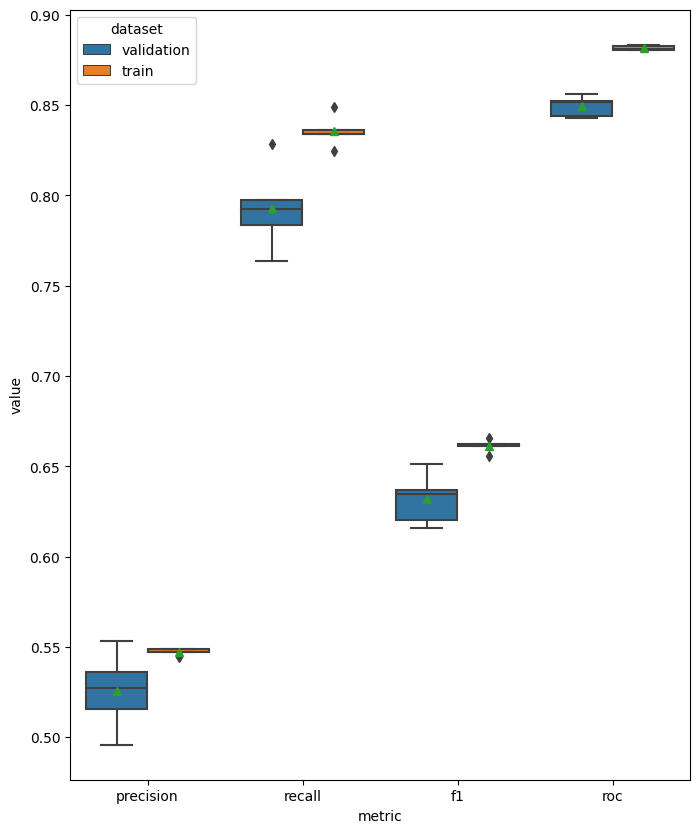

In [49]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Your plotting code here

plt.figure(figsize=(8, 10))
sns.boxplot(data=best_results_df, y="value", x="metric", hue="dataset", showmeans=True)
plt.show()

In [50]:
train_val_preds = grid_RF.best_estimator_.predict(X_train)
test_preds = grid_RF.best_estimator_.predict(X_test)

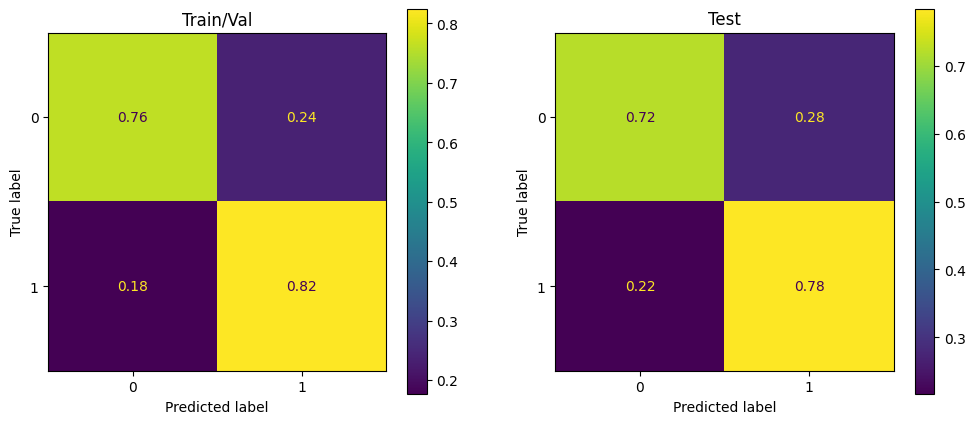

In [51]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

train_val_cm = confusion_matrix(y_train, train_val_preds, labels=grid_RF.best_estimator_.classes_, normalize="true")
train_val_disp = ConfusionMatrixDisplay(confusion_matrix=train_val_cm, display_labels=grid_RF.best_estimator_.classes_)
train_val_disp.plot(ax=axes[0])
axes[0].set_title("Train/Val")

test_cm = confusion_matrix(y_test, test_preds, labels=grid_RF.best_estimator_.classes_, normalize="true")
test_disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=grid_RF.best_estimator_.classes_)
test_disp.plot(ax=axes[1])
axes[1].set_title("Test")

plt.show()

Text(0.5, 1.0, 'Test')

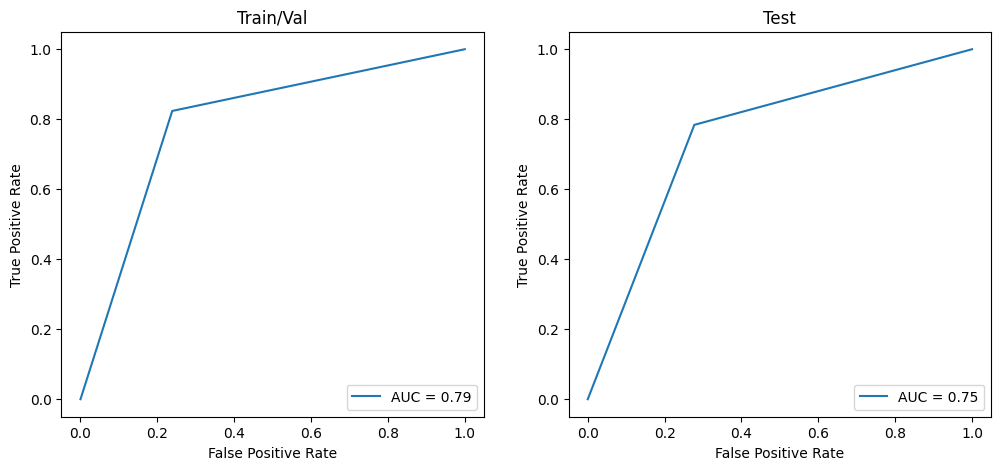

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

fpr, tpr, thresholds = roc_curve(y_train, train_val_preds)
area = auc(fpr, tpr)
train_val_disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=area)
train_val_disp.plot(ax=axes[0])
axes[0].set_title("Train/Val")

fpr, tpr, thresholds = roc_curve(y_test, test_preds)
area = auc(fpr, tpr)
test_disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=area)
test_disp.plot(ax=axes[1])
axes[1].set_title("Test")

In [53]:
print("Precision:")
print("- Train/Val:", precision_score(y_train, train_val_preds))
print("- Test:", precision_score(y_test, test_preds))
print("\nRecall:")
print("- Train/Val:", recall_score(y_train, train_val_preds))
print("- Test:", recall_score(y_test, test_preds))
print("\nF1:")
print("- Train/Val:", f1_score(y_train, train_val_preds))
print("- Test:", f1_score(y_test, test_preds))
print("\nROC AUC:")
print("- Train/Val:", roc_auc_score(y_train, train_val_preds))
print("- Test:", roc_auc_score(y_test, test_preds))

Precision:
- Train/Val: 0.5452322738386308
- Test: 0.5270805812417437

Recall:
- Train/Val: 0.8236380424746076
- Test: 0.7838899803536346

F1:
- Train/Val: 0.6561235748436925
- Test: 0.6303317535545023

ROC AUC:
- Train/Val: 0.7924734966944742
- Test: 0.7532927825858026


In [54]:
f1_scorer = make_scorer(f1_score)
cross_val_results = cross_val_score(grid_RF.best_estimator_, X_train, y_train, cv=5, scoring=f1_scorer)
print("Cross-Validation F1 for Random Forrest:", cross_val_results)
print("Mean Cross-Validation F1 for Random Forrest:", cross_val_results.mean())
MODELOS_F1["Random Forrest"] = cross_val_results.mean()

Cross-Validation F1 for Random Forrest: [0.62045061 0.61567164 0.63486239 0.63670412 0.65151515]
Mean Cross-Validation F1 for Random Forrest: 0.6318407810126546


In [55]:
test_probs = grid_RF.best_estimator_.predict_proba(X_test)[:,1]
probs_true_df = pd.DataFrame(np.append(test_probs.reshape(-1, 1), y_test.values.reshape(-1, 1), axis=1), columns=["probs", "true"])

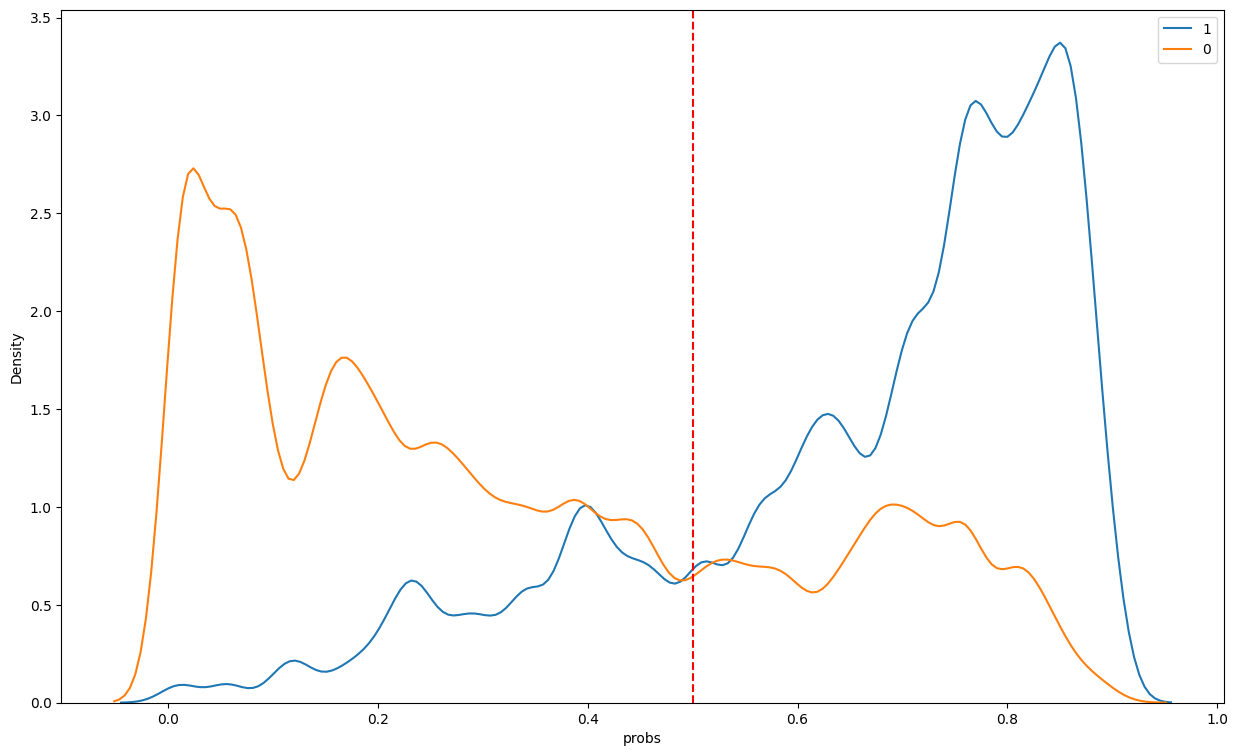

In [56]:
plt.figure(figsize=(15, 9))
sns.kdeplot(data=probs_true_df.loc[probs_true_df["true"] == 1], x="probs", bw_adjust=.3, label="1")
sns.kdeplot(data=probs_true_df.loc[probs_true_df["true"] == 0], x="probs", bw_adjust=.3, label="0")
plt.axvline(x=.5, color="r", linestyle="--")
plt.legend()
plt.show()

*Conclusiones:*

En términos de recall, el nuevo modelo es significativamente mejor que el modelo base. Esto significa que el nuevo modelo es más propenso a identificar correctamente los casos positivos.

En términos de precisión y puntuación F1, el nuevo modelo es ligeramente mejor que el modelo base. Sin embargo, estas mejoras son relativamente pequeñas.

En términos de AUC ROC, el nuevo modelo es ligeramente peor que el modelo base. Esto significa que el nuevo modelo es menos propenso a clasificar correctamente los casos positivos y negativos.

## Arbol de Decisión

<div style="background-color: skyblue; height: 2px;"></div>

In [57]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, roc_auc_score

model = DecisionTreeClassifier(random_state=10)

pipeline_Decision_Tree = Pipeline([
    ('feature_selector', feature_selector),
    ("classifier",  model)
])

param_grid = {
    'feature_selector__k': Feature_vector,
    "classifier__max_depth": [3, 4, 5, 6],
    "classifier__class_weight": ["balanced", None]
}

grid_DT = GridSearchCV(estimator=pipeline_Decision_Tree, param_grid=param_grid, scoring=["precision", "recall", "f1", "roc_auc"], refit="f1", cv=5, return_train_score=True)
grid_DT.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('feature_selector', SelectKBest()),
                                       ('classifier',
                                        DecisionTreeClassifier(random_state=10))]),
             param_grid={'classifier__class_weight': ['balanced', None],
                         'classifier__max_depth': [3, 4, 5, 6],
                         'feature_selector__k': [3, 6, 9, 12, 15, 18, 21, 24,
                                                 27, 30, 33]},
             refit='f1', return_train_score=True,
             scoring=['precision', 'recall', 'f1', 'roc_auc'])

In [58]:
grid_DT.best_params_

{'classifier__class_weight': 'balanced',
 'classifier__max_depth': 6,
 'feature_selector__k': 15}

In [59]:
best_results_df = pd.DataFrame(grid_DT.cv_results_).iloc[grid_DT.best_index_].reset_index().rename(columns={"index": "result", grid_DT.best_index_: "value"})
best_results_df = best_results_df.loc[best_results_df["result"].str.contains("split")]
[best_results_df["split"], best_results_df["dataset"], best_results_df["metric"]] = zip(*best_results_df["result"].str.split("_"))
best_results_df["dataset"].replace({"test": "validation"}, inplace=True)
del best_results_df["result"]

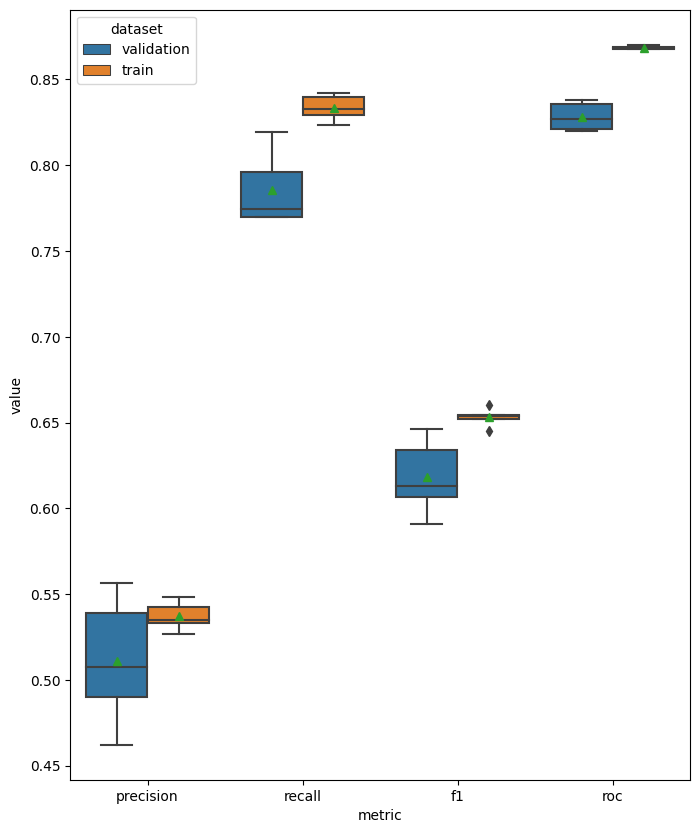

In [60]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Your plotting code here

plt.figure(figsize=(8, 10))
sns.boxplot(data=best_results_df, y="value", x="metric", hue="dataset", showmeans=True)
plt.show()

In [61]:
train_val_preds = grid_DT.best_estimator_.predict(X_train)
test_preds = grid_DT.best_estimator_.predict(X_test)

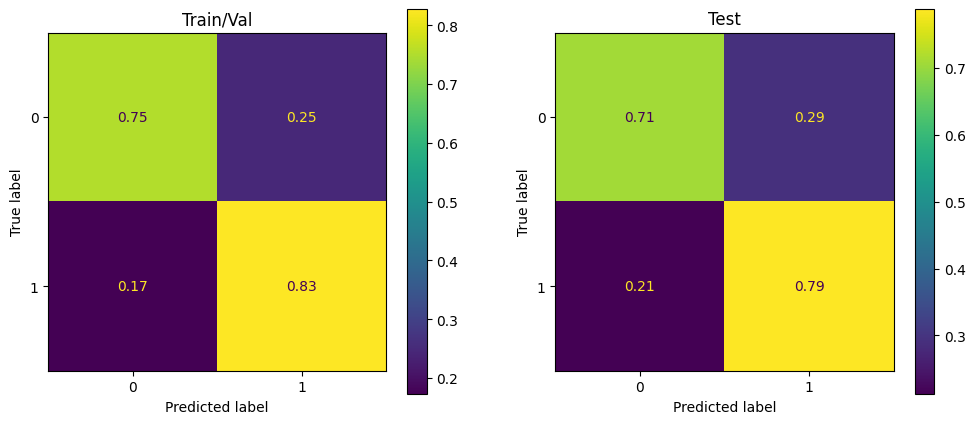

In [62]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

train_val_cm = confusion_matrix(y_train, train_val_preds, labels=grid_DT.best_estimator_.classes_, normalize="true")
train_val_disp = ConfusionMatrixDisplay(confusion_matrix=train_val_cm, display_labels=grid_DT.best_estimator_.classes_)
train_val_disp.plot(ax=axes[0])
axes[0].set_title("Train/Val")

test_cm = confusion_matrix(y_test, test_preds, labels=grid_DT.best_estimator_.classes_, normalize="true")
test_disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=grid_DT.best_estimator_.classes_)
test_disp.plot(ax=axes[1])
axes[1].set_title("Test")

plt.show()

Text(0.5, 1.0, 'Test')

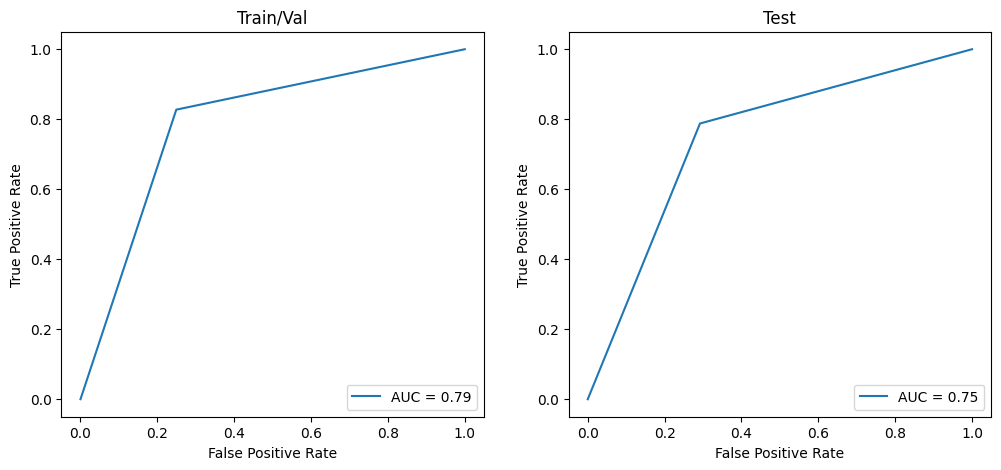

In [63]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

fpr, tpr, thresholds = roc_curve(y_train, train_val_preds)
area = auc(fpr, tpr)
train_val_disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=area)
train_val_disp.plot(ax=axes[0])
axes[0].set_title("Train/Val")

fpr, tpr, thresholds = roc_curve(y_test, test_preds)
area = auc(fpr, tpr)
test_disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=area)
test_disp.plot(ax=axes[1])
axes[1].set_title("Test")

In [64]:
print("Precision:")
print("- Train/Val:", precision_score(y_train, train_val_preds))
print("- Test:", precision_score(y_test, test_preds))
print("\nRecall:")
print("- Train/Val:", recall_score(y_train, train_val_preds))
print("- Test:", recall_score(y_test, test_preds))
print("\nF1:")
print("- Train/Val:", f1_score(y_train, train_val_preds))
print("- Test:", f1_score(y_test, test_preds))
print("\nROC AUC:")
print("- Train/Val:", roc_auc_score(y_train, train_val_preds))
print("- Test:", roc_auc_score(y_test, test_preds))

Precision:
- Train/Val: 0.5355648535564853
- Test: 0.5154241645244216

Recall:
- Train/Val: 0.827331486611265
- Test: 0.787819253438114

F1:
- Train/Val: 0.6502177068214804
- Test: 0.6231546231546232

ROC AUC:
- Train/Val: 0.7890266672709839
- Test: 0.7478987824123181


In [65]:
f1_scorer = make_scorer(f1_score)
cross_val_results = cross_val_score(grid_DT.best_estimator_, X_train, y_train, cv=5, scoring=f1_scorer)
print("Cross-Validation F1 for Decision Tree:", cross_val_results)
print("Mean Cross-Validation F1 for Decision Tree:", cross_val_results.mean())
MODELOS_F1["Decision Tree"] = cross_val_results.mean()

Cross-Validation F1 for Decision Tree: [0.59098497 0.60670194 0.61313869 0.63377609 0.64603482]
Mean Cross-Validation F1 for Decision Tree: 0.61812730169082


In [66]:
test_probs = grid_DT.best_estimator_.predict_proba(X_test)[:,1]
probs_true_df = pd.DataFrame(np.append(test_probs.reshape(-1, 1), y_test.values.reshape(-1, 1), axis=1), columns=["probs", "true"])

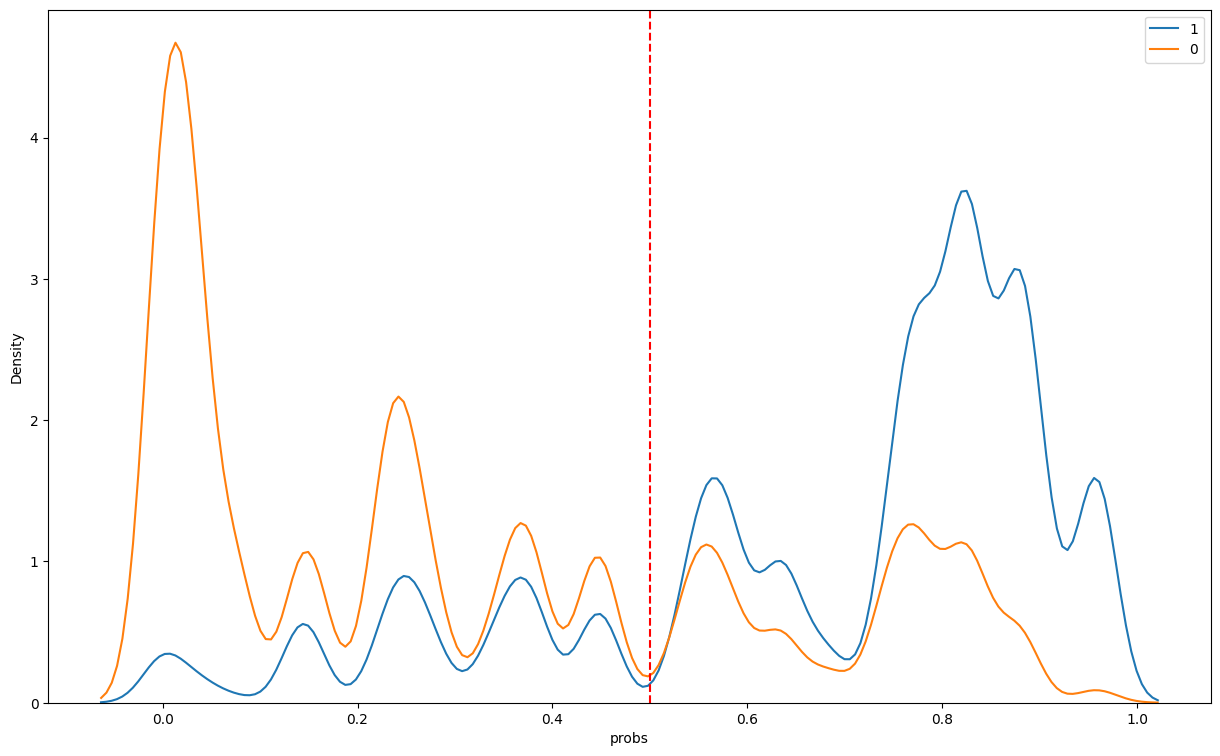

In [67]:
plt.figure(figsize=(15, 9))
sns.kdeplot(data=probs_true_df.loc[probs_true_df["true"] == 1], x="probs", bw_adjust=.3, label="1")
sns.kdeplot(data=probs_true_df.loc[probs_true_df["true"] == 0], x="probs", bw_adjust=.3, label="0")
plt.axvline(x=.5, color="r", linestyle="--")
plt.legend()
plt.show()

*Conclusiones:*

En base a las métricas proporcionadas, se puede concluir que el modelo de referencia es el mejor en términos de precisión, mientras que el modelo Random Forest es el mejor en términos de recall y F1. El nuevo modelo tiene un rendimiento similar al modelo de referencia en términos de precisión y al modelo Random Forest en términos de recall. Sin embargo, el nuevo modelo tiene un AUC ROC ligeramente inferior al de ambos modelos.

## Gradient Boosting

<div style="background-color: skyblue; height: 2px;"></div>

In [68]:
#!pip install xgboost

In [69]:
from xgboost import XGBClassifier

model = XGBClassifier(random_state=10)

pipeline_Gradient_Boosting = Pipeline([
    ('feature_selector', feature_selector),
    ("classifier",  model)
])

param_grid = {
    'feature_selector__k': Feature_vector,
    'classifier__n_estimators': [50, 100, 150],
    'classifier__max_depth': [3, 4, 5],
    'classifier__learning_rate': [0.01, 0.1, 0.2]
}

grid_GB = GridSearchCV(estimator=pipeline_Gradient_Boosting, param_grid=param_grid, scoring=["precision", "recall", "f1", "roc_auc"], refit="f1", cv=5, return_train_score=True)
grid_GB.fit(X_train, y_train)

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zer

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('feature_selector', SelectKBest()),
                                       ('classifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None,
                                                      grow_policy=None,
                                                      impo...
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=10, ...))]),
             param_grid={'classifier__learning_rate': [0.01, 0.1, 0.2],
                         'classifier__max_depth': [3, 4, 5],
                         'classifier__n_estimators': [50, 100, 150],
                         'feature_selector__k': [3, 6, 9, 12, 15, 18, 21, 24,
                                                 27, 30, 33]},
             refit='f1', return_train_score=True,
             scoring=['precision', 'recall', 'f1', 'roc_auc'])

In [70]:
best_results_df = pd.DataFrame(grid_GB.cv_results_).iloc[grid_GB.best_index_].reset_index().rename(columns={"index": "result", grid_GB.best_index_: "value"})
best_results_df = best_results_df.loc[best_results_df["result"].str.contains("split")]
[best_results_df["split"], best_results_df["dataset"], best_results_df["metric"]] = zip(*best_results_df["result"].str.split("_"))
best_results_df["dataset"].replace({"test": "validation"}, inplace=True)
del best_results_df["result"]

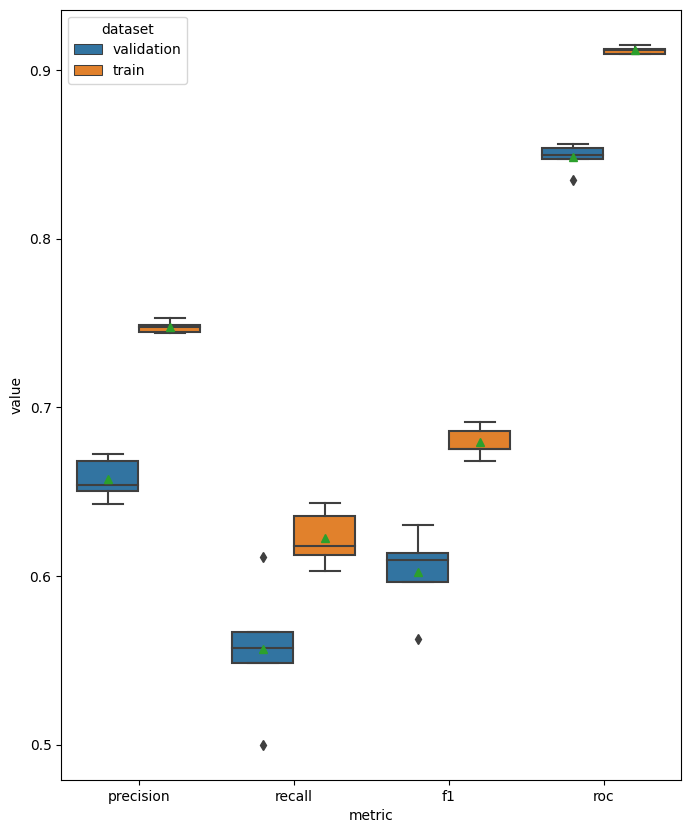

In [71]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Your plotting code here

plt.figure(figsize=(8, 10))
sns.boxplot(data=best_results_df, y="value", x="metric", hue="dataset", showmeans=True)
plt.show()

In [72]:
train_val_preds = grid_GB.best_estimator_.predict(X_train)
test_preds = grid_GB.best_estimator_.predict(X_test)

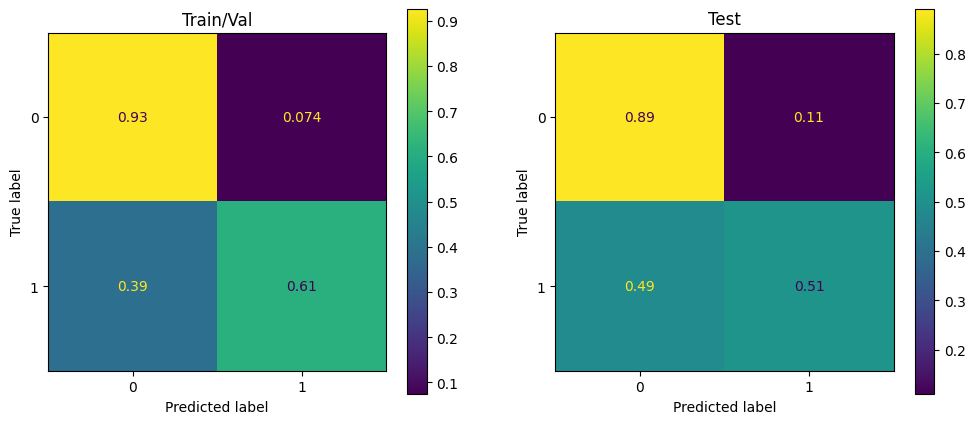

In [73]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

train_val_cm = confusion_matrix(y_train, train_val_preds, labels=grid_GB.best_estimator_.classes_, normalize="true")
train_val_disp = ConfusionMatrixDisplay(confusion_matrix=train_val_cm, display_labels=grid_GB.best_estimator_.classes_)
train_val_disp.plot(ax=axes[0])
axes[0].set_title("Train/Val")

test_cm = confusion_matrix(y_test, test_preds, labels=grid_GB.best_estimator_.classes_, normalize="true")
test_disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=grid_GB.best_estimator_.classes_)
test_disp.plot(ax=axes[1])
axes[1].set_title("Test")

plt.show()

Text(0.5, 1.0, 'Test')

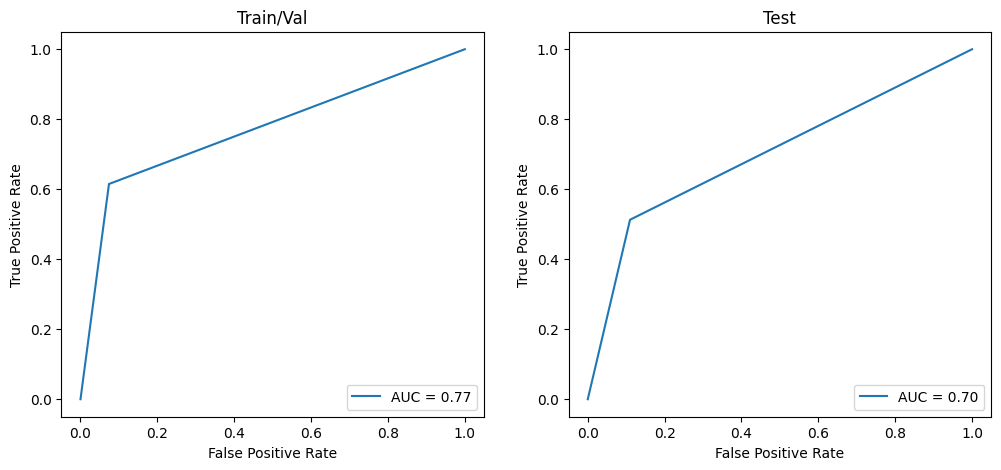

In [74]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

fpr, tpr, thresholds = roc_curve(y_train, train_val_preds)
area = auc(fpr, tpr)
train_val_disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=area)
train_val_disp.plot(ax=axes[0])
axes[0].set_title("Train/Val")

fpr, tpr, thresholds = roc_curve(y_test, test_preds)
area = auc(fpr, tpr)
test_disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=area)
test_disp.plot(ax=axes[1])
axes[1].set_title("Test")

In [75]:
print("Precision:")
print("- Train/Val:", precision_score(y_train, train_val_preds))
print("- Test:", precision_score(y_test, test_preds))
print("\nRecall:")
print("- Train/Val:", recall_score(y_train, train_val_preds))
print("- Test:", recall_score(y_test, test_preds))
print("\nF1:")
print("- Train/Val:", f1_score(y_train, train_val_preds))
print("- Test:", f1_score(y_test, test_preds))
print("\nROC AUC:")
print("- Train/Val:", roc_auc_score(y_train, train_val_preds))
print("- Test:", roc_auc_score(y_test, test_preds))

Precision:
- Train/Val: 0.7424749163879598
- Test: 0.6476426799007444

Recall:
- Train/Val: 0.6149584487534626
- Test: 0.5127701375245579

F1:
- Train/Val: 0.6727272727272727
- Test: 0.5723684210526315

ROC AUC:
- Train/Val: 0.7704243639339978
- Test: 0.7013889417289714


In [76]:
f1_scorer = make_scorer(f1_score)
cross_val_results = cross_val_score(grid_GB.best_estimator_, X_train, y_train, cv=5, scoring=f1_scorer)
print("Cross-Validation F1 for Gradient Boosting:", cross_val_results)
print("Mean Cross-Validation F1 for Gradient Boosting:", cross_val_results.mean())
MODELOS_F1["Gradient Boosting"] = cross_val_results.mean()

Cross-Validation F1 for Gradient Boosting: [0.6300716  0.5625     0.60957179 0.59649123 0.61346633]
Mean Cross-Validation F1 for Gradient Boosting: 0.6024201899386417


In [77]:
test_probs = grid_GB.best_estimator_.predict_proba(X_test)[:,1]
probs_true_df = pd.DataFrame(np.append(test_probs.reshape(-1, 1), y_test.values.reshape(-1, 1), axis=1), columns=["probs", "true"])

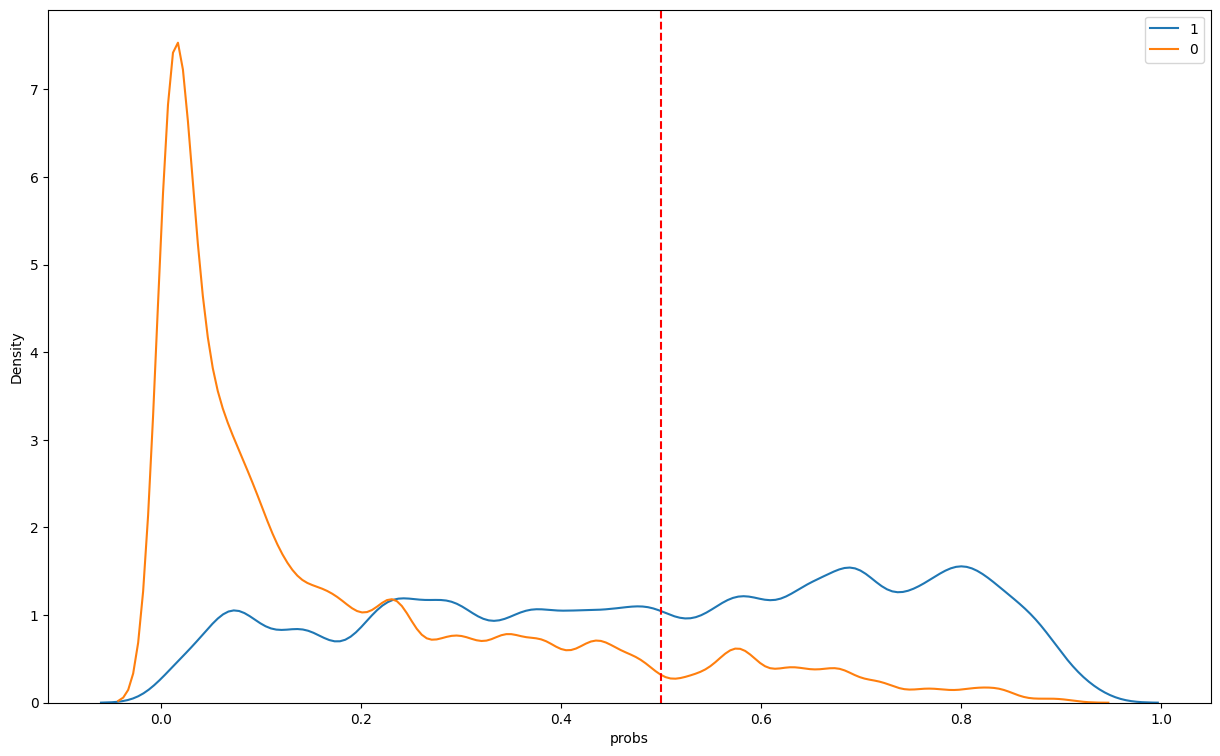

In [78]:
plt.figure(figsize=(15, 9))
sns.kdeplot(data=probs_true_df.loc[probs_true_df["true"] == 1], x="probs", bw_adjust=.3, label="1")
sns.kdeplot(data=probs_true_df.loc[probs_true_df["true"] == 0], x="probs", bw_adjust=.3, label="0")
plt.axvline(x=.5, color="r", linestyle="--")
plt.legend()
plt.show()

*Conclusiones:*

- El modelo Random Forest es el mejor en términos de F1. Esto significa que el modelo Random Forest es mejor para clasificar correctamente tanto los casos positivos como los negativos.
- El modelo de referencia es el mejor en términos de precisión y AUC ROC. Esto significa que el modelo de referencia es mejor para evitar clasificar erróneamente los casos positivos como negativos.
- El árbol de decisión y el nuevo modelo tienen un rendimiento similar. El árbol de decisión tiene un mejor rendimiento en términos de precisión y AUC ROC, mientras que el nuevo modelo tiene un mejor rendimiento en términos de recall.

## Regresión Logistica

<div style="background-color: skyblue; height: 2px;"></div>

In [79]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=10)

pipeline_Logistic_Regression = Pipeline([
    ('feature_selector', feature_selector),
    ("classifier",  model)
])

param_grid = {
    'feature_selector__k': Feature_vector,
    'classifier__penalty': ['l1', 'l2', 'elasticnet'],
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__solver': ['liblinear', 'saga']
}

grid_RL = GridSearchCV(estimator=pipeline_Logistic_Regression, param_grid=param_grid, scoring=["precision", "recall", "f1", "roc_auc"], refit="f1", cv=5, return_train_score=True)
grid_RL.fit(X_train, y_train)


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zer

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('feature_selector', SelectKBest()),
                                       ('classifier',
                                        LogisticRegression(random_state=10))]),
             param_grid={'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'classifier__penalty': ['l1', 'l2', 'elasticnet'],
                         'classifier__solver': ['liblinear', 'saga'],
                         'feature_selector__k': [3, 6, 9, 12, 15, 18, 21, 24,
                                                 27, 30, 33]},
             refit='f1', return_train_score=True,
             scoring=['precision', 'recall', 'f1', 'roc_auc'])

In [80]:
grid_RL.best_params_

{'classifier__C': 0.1,
 'classifier__penalty': 'l2',
 'classifier__solver': 'liblinear',
 'feature_selector__k': 27}

In [81]:
best_results_df = pd.DataFrame(grid_RL.cv_results_).iloc[grid_RL.best_index_].reset_index().rename(columns={"index": "result", grid_RL.best_index_: "value"})
best_results_df = best_results_df.loc[best_results_df["result"].str.contains("split")]
[best_results_df["split"], best_results_df["dataset"], best_results_df["metric"]] = zip(*best_results_df["result"].str.split("_"))
best_results_df["dataset"].replace({"test": "validation"}, inplace=True)
del best_results_df["result"]

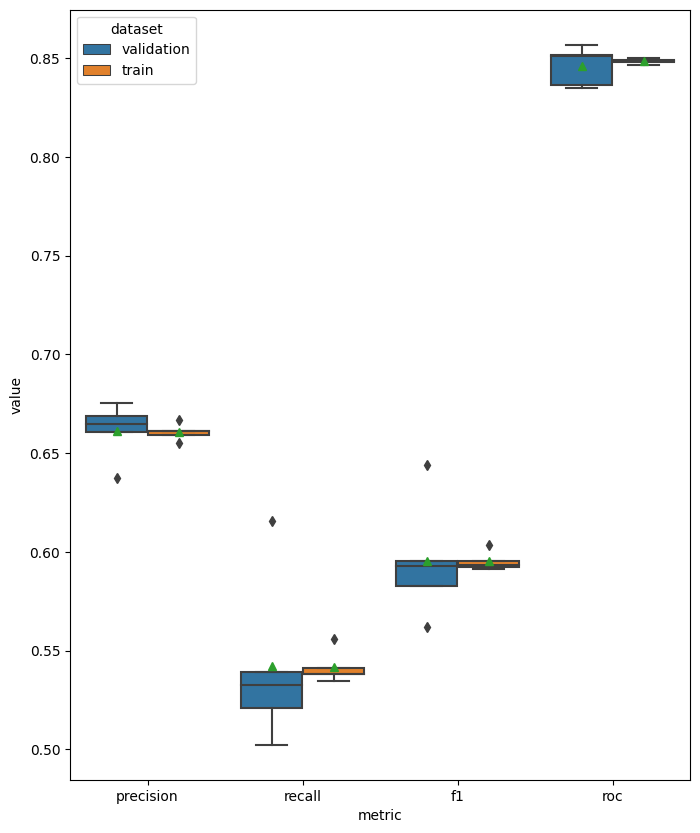

In [82]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Your plotting code here

plt.figure(figsize=(8, 10))
sns.boxplot(data=best_results_df, y="value", x="metric", hue="dataset", showmeans=True)
plt.show()

In [83]:
train_val_preds = grid_RL.best_estimator_.predict(X_train)
test_preds = grid_RL.best_estimator_.predict(X_test)

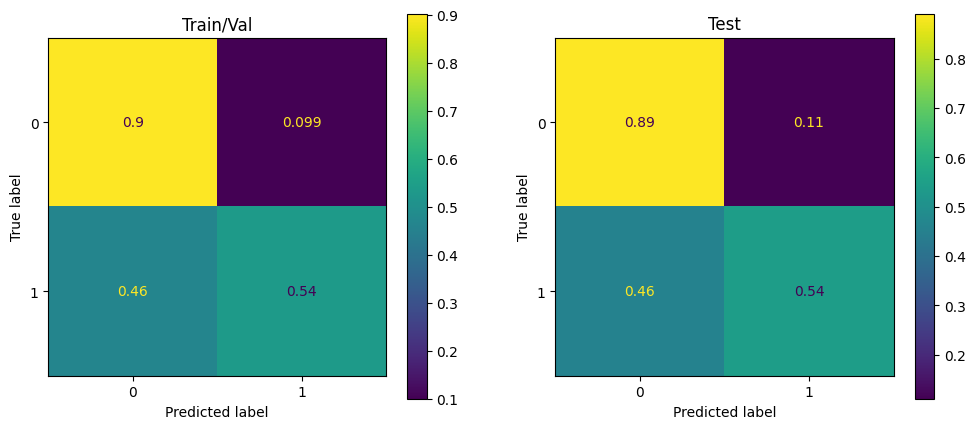

In [84]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

train_val_cm = confusion_matrix(y_train, train_val_preds, labels=grid_RL.best_estimator_.classes_, normalize="true")
train_val_disp = ConfusionMatrixDisplay(confusion_matrix=train_val_cm, display_labels=grid_RL.best_estimator_.classes_)
train_val_disp.plot(ax=axes[0])
axes[0].set_title("Train/Val")

test_cm = confusion_matrix(y_test, test_preds, labels=grid_RL.best_estimator_.classes_, normalize="true")
test_disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=grid_RL.best_estimator_.classes_)
test_disp.plot(ax=axes[1])
axes[1].set_title("Test")

plt.show()

Text(0.5, 1.0, 'Test')

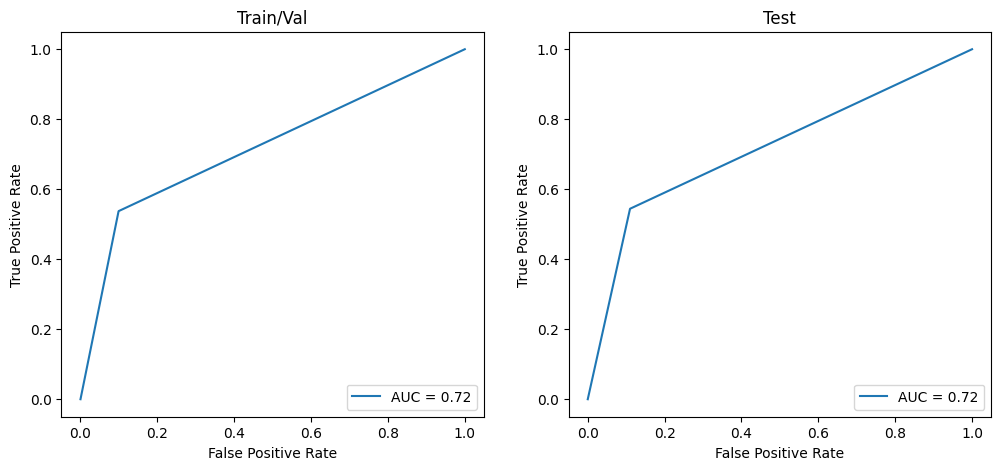

In [85]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

fpr, tpr, thresholds = roc_curve(y_train, train_val_preds)
area = auc(fpr, tpr)
train_val_disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=area)
train_val_disp.plot(ax=axes[0])
axes[0].set_title("Train/Val")

fpr, tpr, thresholds = roc_curve(y_test, test_preds)
area = auc(fpr, tpr)
test_disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=area)
test_disp.plot(ax=axes[1])
axes[1].set_title("Test")

In [86]:
print("Precision:")
print("- Train/Val:", precision_score(y_train, train_val_preds))
print("- Test:", precision_score(y_test, test_preds))
print("\nRecall:")
print("- Train/Val:", recall_score(y_train, train_val_preds))
print("- Test:", recall_score(y_test, test_preds))
print("\nF1:")
print("- Train/Val:", f1_score(y_train, train_val_preds))
print("- Test:", f1_score(y_test, test_preds))
print("\nROC AUC:")
print("- Train/Val:", roc_auc_score(y_train, train_val_preds))
print("- Test:", roc_auc_score(y_test, test_preds))

Precision:
- Train/Val: 0.6531986531986532
- Test: 0.6610978520286396

Recall:
- Train/Val: 0.5373961218836565
- Test: 0.5442043222003929

F1:
- Train/Val: 0.5896656534954406
- Test: 0.5969827586206896

ROC AUC:
- Train/Val: 0.7191311697002498
- Test: 0.7171060340668889


In [87]:
f1_scorer = make_scorer(f1_score)
cross_val_results = cross_val_score(grid_RL.best_estimator_, X_train, y_train, cv=5, scoring=f1_scorer)
print("Cross-Validation F1 for Logistic Regression:", cross_val_results)
print("Mean Cross-Validation F1 for Logistic Regression:", cross_val_results.mean())
MODELOS_F1["Logistic Regression"] = cross_val_results.mean()

Cross-Validation F1 for Logistic Regression: [0.6440678  0.59278351 0.56185567 0.58247423 0.59541985]
Mean Cross-Validation F1 for Logistic Regression: 0.595320209200054


In [88]:
test_probs = grid_RL.best_estimator_.predict_proba(X_test)[:,1]
probs_true_df = pd.DataFrame(np.append(test_probs.reshape(-1, 1), y_test.values.reshape(-1, 1), axis=1), columns=["probs", "true"])

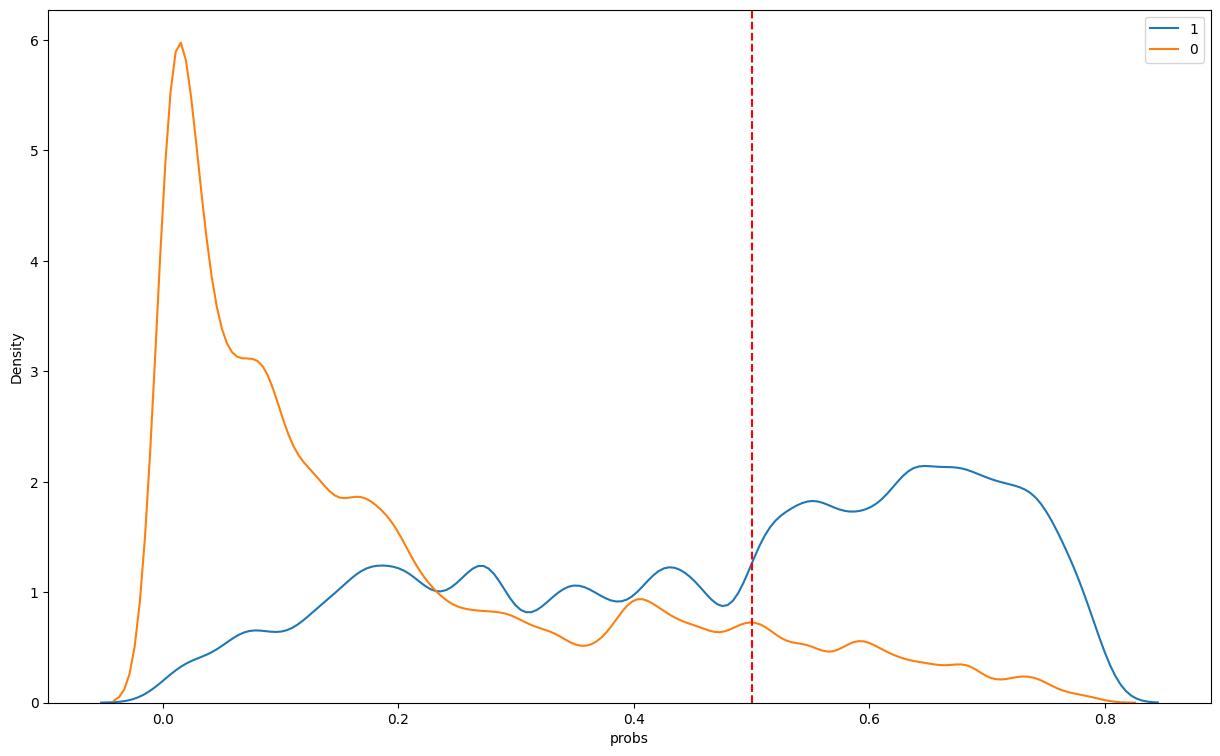

In [89]:
plt.figure(figsize=(15, 9))
sns.kdeplot(data=probs_true_df.loc[probs_true_df["true"] == 1], x="probs", bw_adjust=.3, label="1")
sns.kdeplot(data=probs_true_df.loc[probs_true_df["true"] == 0], x="probs", bw_adjust=.3, label="0")
plt.axvline(x=.5, color="r", linestyle="--")
plt.legend()
plt.show()

*Conclusiones:*

El modelo de referencia tiene una precisión de 0.66, pero tiene un recall inferior de 0.50. Esto significa que el modelo de referencia es bueno para evitar clasificar erróneamente los casos positivos como negativos, pero no es tan bueno para identificar correctamente los casos positivos.

El modelo Random Forest tiene una precisión comparable a la del modelo de referencia, pero tiene un recall superior. Esto significa que el modelo Random Forest es mejor para identificar correctamente los casos positivos, sin sacrificar demasiado la precisión.

El árbol de decisión y el Gradient Boosting tienen un rendimiento similar al del modelo de referencia en términos de precisión y recall. Sin embargo, ambos modelos tienen un recall inferior al del modelo Random Forest.

El nuevo modelo tiene un rendimiento similar al del modelo de referencia en términos de precisión y recall. Sin embargo, el nuevo modelo tiene un recall inferior al del modelo Random Forest.

En conclusión, el modelo Random Forest es el mejor modelo de los cinco, ya que tiene una puntuación F1 superior.

## Red Neuronal

<div style="background-color: skyblue; height: 2px;"></div>

In [90]:
#!pip install xgboost

In [91]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(random_state=10)

pipeline_Neural_Network = Pipeline([
    ('feature_selector', feature_selector),
    ("classifier",  model)
])

param_grid = {
    'feature_selector__k': Feature_vector,
    'classifier__hidden_layer_sizes': [(100,), (50, 50), (30, 30, 30)],
    'classifier__activation': ['logistic', 'tanh', 'relu'],
    'classifier__alpha': [0.0001, 0.001, 0.01],
    'classifier__learning_rate': ['constant', 'invscaling', 'adaptive']
}

grid_NN = GridSearchCV(estimator=pipeline_Neural_Network, param_grid=param_grid, scoring=["precision", "recall", "f1", "roc_auc"], refit="f1", cv=5, return_train_score=True)
grid_NN.fit(X_train, y_train)

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('feature_selector', SelectKBest()),
                                       ('classifier',
                                        MLPClassifier(random_state=10))]),
             param_grid={'classifier__activation': ['logistic', 'tanh', 'relu'],
                         'classifier__alpha': [0.0001, 0.001, 0.01],
                         'classifier__hidden_layer_sizes': [(100,), (50, 50),
                                                            (30, 30, 30)],
                         'classifier__learning_rate': ['constant', 'invscaling',
                                                       'adaptive'],
                         'feature_selector__k': [3, 6, 9, 12, 15, 18, 21, 24,
                                                 27, 30, 33]},
             refit='f1', return_train_score=True,
             scoring=['precision', 'recall', 'f1', 'roc_auc'])

In [92]:
grid_NN.best_params_

{'classifier__activation': 'relu',
 'classifier__alpha': 0.0001,
 'classifier__hidden_layer_sizes': (50, 50),
 'classifier__learning_rate': 'constant',
 'feature_selector__k': 6}

In [93]:
best_results_df = pd.DataFrame(grid_NN.cv_results_).iloc[grid_NN.best_index_].reset_index().rename(columns={"index": "result", grid_NN.best_index_: "value"})
best_results_df = best_results_df.loc[best_results_df["result"].str.contains("split")]
[best_results_df["split"], best_results_df["dataset"], best_results_df["metric"]] = zip(*best_results_df["result"].str.split("_"))
best_results_df["dataset"].replace({"test": "validation"}, inplace=True)
del best_results_df["result"]

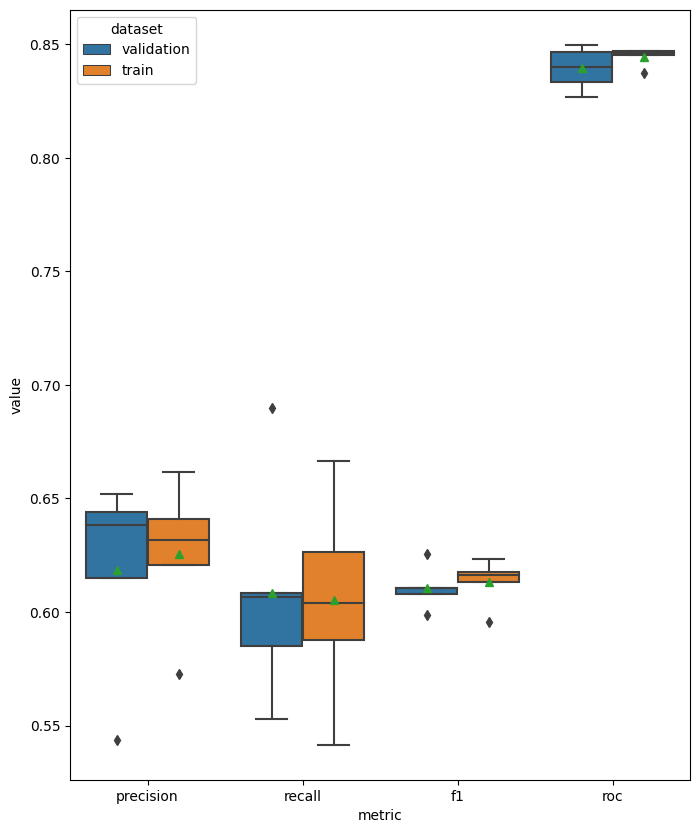

In [94]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Your plotting code here

plt.figure(figsize=(8, 10))
sns.boxplot(data=best_results_df, y="value", x="metric", hue="dataset", showmeans=True)
plt.show()

In [95]:
train_val_preds = grid_NN.best_estimator_.predict(X_train)
test_preds = grid_NN.best_estimator_.predict(X_test)

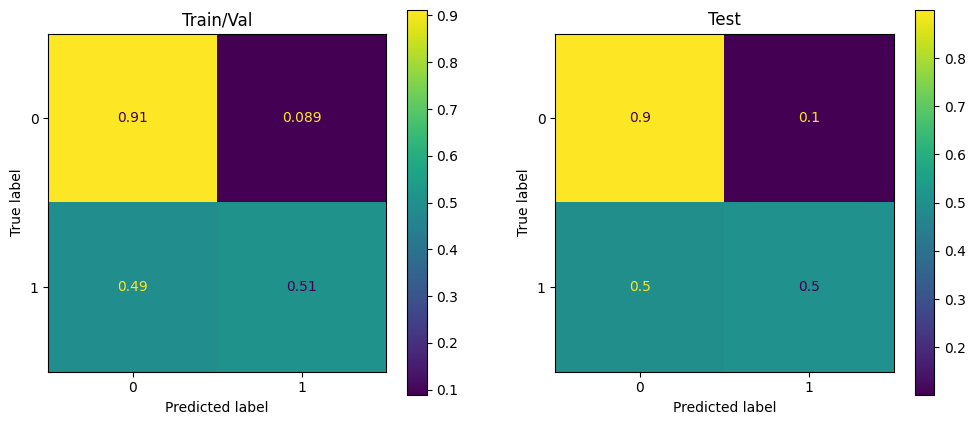

In [96]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

train_val_cm = confusion_matrix(y_train, train_val_preds, labels=grid_NN.best_estimator_.classes_, normalize="true")
train_val_disp = ConfusionMatrixDisplay(confusion_matrix=train_val_cm, display_labels=grid_NN.best_estimator_.classes_)
train_val_disp.plot(ax=axes[0])
axes[0].set_title("Train/Val")

test_cm = confusion_matrix(y_test, test_preds, labels=grid_NN.best_estimator_.classes_, normalize="true")
test_disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=grid_NN.best_estimator_.classes_)
test_disp.plot(ax=axes[1])
axes[1].set_title("Test")

plt.show()

Text(0.5, 1.0, 'Test')

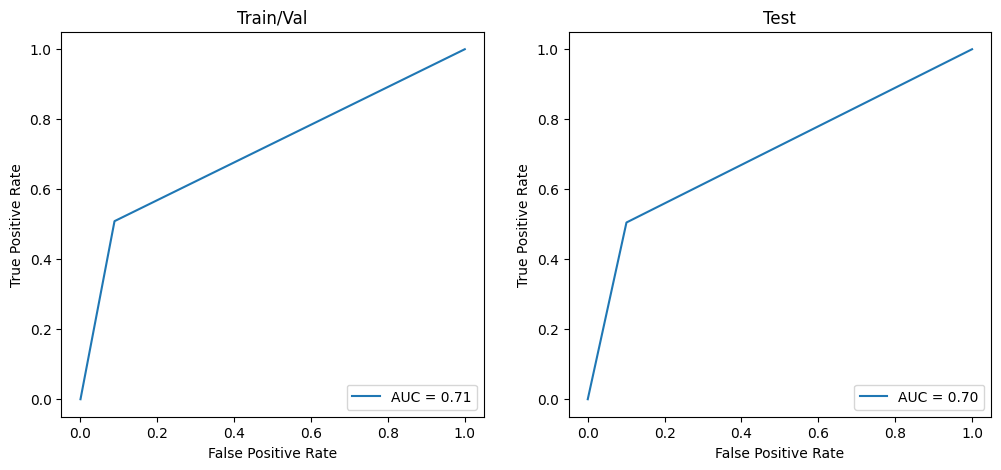

In [97]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

fpr, tpr, thresholds = roc_curve(y_train, train_val_preds)
area = auc(fpr, tpr)
train_val_disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=area)
train_val_disp.plot(ax=axes[0])
axes[0].set_title("Train/Val")

fpr, tpr, thresholds = roc_curve(y_test, test_preds)
area = auc(fpr, tpr)
test_disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=area)
test_disp.plot(ax=axes[1])
axes[1].set_title("Test")

In [98]:
print("Precision:")
print("- Train/Val:", precision_score(y_train, train_val_preds))
print("- Test:", precision_score(y_test, test_preds))
print("\nRecall:")
print("- Train/Val:", recall_score(y_train, train_val_preds))
print("- Test:", recall_score(y_test, test_preds))
print("\nF1:")
print("- Train/Val:", f1_score(y_train, train_val_preds))
print("- Test:", f1_score(y_test, test_preds))
print("\nROC AUC:")
print("- Train/Val:", roc_auc_score(y_train, train_val_preds))
print("- Test:", roc_auc_score(y_test, test_preds))

Precision:
- Train/Val: 0.6662636033857315
- Test: 0.6640826873385013

Recall:
- Train/Val: 0.5087719298245614
- Test: 0.5049115913555993

F1:
- Train/Val: 0.5769633507853403
- Test: 0.5736607142857143

ROC AUC:
- Train/Val: 0.7101126251625213
- Test: 0.7021072286754759


In [99]:
f1_scorer = make_scorer(f1_score)
cross_val_results = cross_val_score(grid_NN.best_estimator_, X_train, y_train, cv=5, scoring=f1_scorer)
print("Cross-Validation F1 for Neural Network:", cross_val_results)
print("Mean Cross-Validation F1 for Neural Network:", cross_val_results.mean())
MODELOS_F1["Neural Network"] = cross_val_results.mean()

Cross-Validation F1 for Neural Network: [0.60816327 0.61072261 0.62559242 0.61057692 0.59850374]
Mean Cross-Validation F1 for Neural Network: 0.6107117913631293


In [100]:
test_probs = grid_NN.best_estimator_.predict_proba(X_test)[:,1]
probs_true_df = pd.DataFrame(np.append(test_probs.reshape(-1, 1), y_test.values.reshape(-1, 1), axis=1), columns=["probs", "true"])

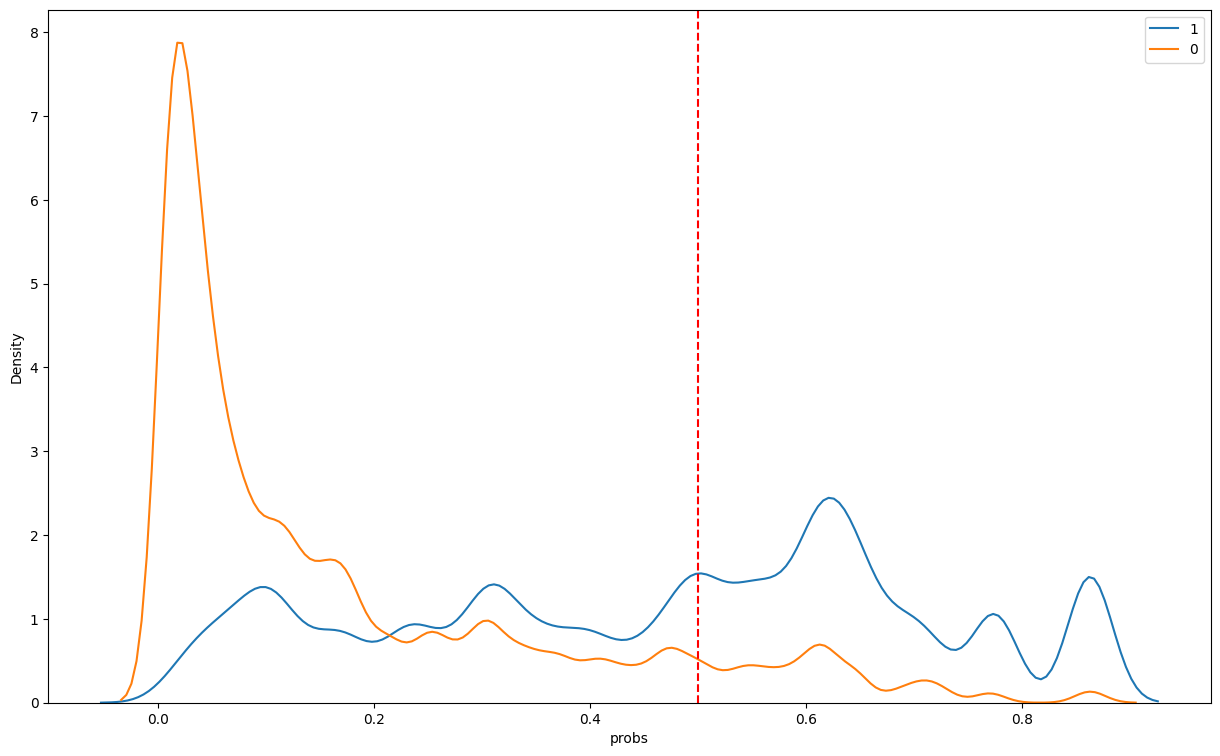

In [101]:
plt.figure(figsize=(15, 9))
sns.kdeplot(data=probs_true_df.loc[probs_true_df["true"] == 1], x="probs", bw_adjust=.3, label="1")
sns.kdeplot(data=probs_true_df.loc[probs_true_df["true"] == 0], x="probs", bw_adjust=.3, label="0")
plt.axvline(x=.5, color="r", linestyle="--")
plt.legend()
plt.show()

*Conclusiones:*

Comparando los modelos de base, Random Forest, Árbol de Decisión, Gradient Boosting y Regresión Logística y Red Neuronal se puede concluir que Random Forest es el mejor modelo para este conjunto de datos. Esto se debe a que tiene el F1 más alto en el conjunto de test, lo que significa que es el mejor modelo para equilibrar la precisión y la recall.

## Conclusión:

In [102]:
MODELOS_F1

{'Random Forrest': 0.6318407810126546,
 'Decision Tree': 0.61812730169082,
 'Gradient Boosting': 0.6024201899386417,
 'Logistic Regression': 0.595320209200054,
 'Neural Network': 0.6107117913631293}

Random Forrest demostró ser el modelo más efectivo, especialmente al considerar principalmente la métrica F1, con los siguientes hiperparámetros optimizados: 
{'classifier__class_weight': 'balanced',
 'classifier__max_depth': 6,
 'classifier__n_estimators': 50,
 'feature_selector__k': 30}

### 4. [30%] Despliegue mediante API REST: 
Construya una API REST utilizando el framework de su preferencia la cual cargue los dos modelos previamente generados (punto 2 y 3) y la cual implemente los siguientes endpoints:
* a. [15%] POST /{model_version}/predict: Este endpoint debe estar en la
capacidad de generar predicciones para cada registro de datos ingresado.
Estos datos deben ser recibidos dentro del body de la solicitud HTTP en
formato JSON y, como respuesta, el endpoint debe devolver para cada
registro el label y la probabilidad de predicción en el mismo orden en el
que se ingresan.
* b. [15%] POST /{model_version}/explain: De forma similar al endpoint
anterior, este debe recibir un conjunto de datos y devolver las “razones” por
las cuales el modelo tomó cierta decisión. Estas razones pueden estar dadas
en términos de las 2 o 3 features que más peso tengan durante la
predicción.

### 5. [20%] A/B testing: 
Utilizando el endpoint de predicción y el conjunto de datos “futuros”, divididos aleatoriamente en 7 días de la semana, simule un escenario en
donde se hagan solicitudes a dicho endpoint mientras aleatoriamente en una
proporción de 50%/50% se varía la versión del modelo (punto 2 y 3) utilizada para la generación de la predicción. Asumiendo que el threshold óptimo para asignar la etiqueta churn o no churn es 0.5, responda a las preguntas:

* a. Para toda la ventana de tiempo, ¿cómo se distribuyen las probabilidades
asignadas por el modelo entre los dos grupos? Asumiendo que las
distribuciones tienen un comportamiento normal, ¿dichas diferencias entre
las probabilidades de ambas variantes del modelo son significativas?
* b. ¿Cuál fue el incremento o decremento porcentual diario de predicción de
casos de churn que tuvo el mejor modelo (punto 3) respecto al baseline
(punto 2)?
* c. En una base diaria, ¿cuál fue el porcentaje de éxito del modelo prediciendo
casos de efectivos de churn?

# MODEL SAVING

In [103]:
import joblib

In [104]:
#Selected model, Random Forrest
grid_RF.best_estimator_

Pipeline(steps=[('feature_selector', SelectKBest(k=30)),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=6,
                                        n_estimators=50, random_state=10))])

In [105]:
#dump
joblib.dump(grid_RF.best_estimator_,'./models/churn-v1.0.joblib')

['./models/churn-v1.0.joblib']

In [106]:
#Baseline model
pipeline_Baseline.named_steps['model']

LogisticRegression()

In [107]:
#Dump
joblib.dump(pipeline_Baseline.named_steps['model'],'./models/churn-baseline-v1.0.joblib')

['./models/churn-baseline-v1.0.joblib']